# Computer Vision III: Detection, Segmentation and Tracking (CV3DST) Exercise ReID

In this exercise, we investigate appearance-based tracking by training a ReID network that we apply on the [MOT16](https://motchallenge.net/data/MOT16/) dataset. Your task is

- to implement Hungarian matching in the tracker.
- to train a small ReID dataset with cross-entropy and triplet-loss.
- to apply the trained ReID network on the detected MOT16 bounding boxes.


## Setup

### Download and extract project data to your Google Drive

1.   **Required**: Please follow all instructions of exercise 0 before running this notebook.
2.   Save this notebook to your Google Drive by clicking `Save a copy in Drive` from the `File` menu.
3.   Download [this](https://vision.in.tum.de/webshare/u/webermar/cv3dst_reid_exercise.zip) zip file to your desktop, extract it and upload it into the `Colab Notebooks` folder in your Google Drive.

#### Connect the notebook to your Google Drive

In [1]:
using_local = True
if not using_local:
    from google.colab import drive
    drive.mount('/content/gdrive')

We're unzipping the dataset to the colab disk.

In [2]:
'''if using_local:
    !unzip "cv3dst_reid_exercise/data.zip"
else:
    !unzip "gdrive/My Drive/Colab Notebooks/cv3dst_reid_exercise/data.zip"'''

'if using_local:\n    !unzip "cv3dst_reid_exercise/data.zip"\nelse:\n    !unzip "gdrive/My Drive/Colab Notebooks/cv3dst_reid_exercise/data.zip"'

In [3]:
if using_local:
    root_dir = "cv3dst_exercise"
    reid_root_dir = "cv3dst_reid_exercise"
else:
    root_dir = "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/"
    reid_root_dir = "gdrive/My Drive/Colab Notebooks/cv3dst_reid_exercise/"

The `root_dir` path points to the directory and the content in your Google Drive.

In [4]:
if using_local:
    !ls "cv3dst_reid_exercise"
    !ls "cv3dst_reid_exercise/src/market"
else:
    !ls "gdrive/My Drive/Colab Notebooks/cv3dst_reid_exercise/"
    !ls "gdrive/My Drive/Colab Notebooks/cv3dst_reid_exercise/src/market"

output	src
datamanager.py	__init__.py  models.py	  sampler.py	 utils.py
dataset.py	metrics.py   __pycache__  transforms.py


#### Install and import Python libraries

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(reid_root_dir, 'src'))

#!pip install tqdm lap
#!pip install https://github.com/timmeinhardt/py-motmetrics/archive/fix_pandas_deprecating_warnings.zip

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import DataLoader

from tracker.data_track import MOT16Sequences
from tracker.data_obj_detect import MOT16ObjDetect
from tracker.object_detector import FRCNN_FPN
from tracker.tracker import Tracker, ReIDTracker
from tracker.utils import (plot_sequence, evaluate_mot_accums, get_mot_accum,
                           evaluate_obj_detect, obj_detect_transforms)

from scipy.optimize import linear_sum_assignment as linear_assignment

import motmetrics as mm
mm.lap.default_solver = 'lap'

/home/erick/Documents/CV3DST/CV3_project/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


# MOT16 dataset

The MOT16 challenge provides 7 train and 7 test video sequences with multiple objects (pedestrians) per frame. It includes many challening scenarios with camera movement, high crowdedness and object occlusions. See the [webpage](https://motchallenge.net/data/MOT16/) for video sequences with ground truth annotation.

The `MOT17Sequences` dataset class provides the possibilty to load single sequences, e.g., `seq_name = 'MOT16-02'`, or the entire train/test set, e.g., `seq_name = 'MOT16-train'`.

In [8]:
if using_local:
    !ls "cv3dst_exercise/data/MOT16/train"
    !ls "cv3dst_exercise/data/MOT16/test"
else:
    !ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/train"
    !ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/test"

MOT16-02  MOT16-04  MOT16-05  MOT16-09	MOT16-10  MOT16-11  MOT16-13
MOT16-01  MOT16-03  MOT16-08  MOT16-12


## Example sequences

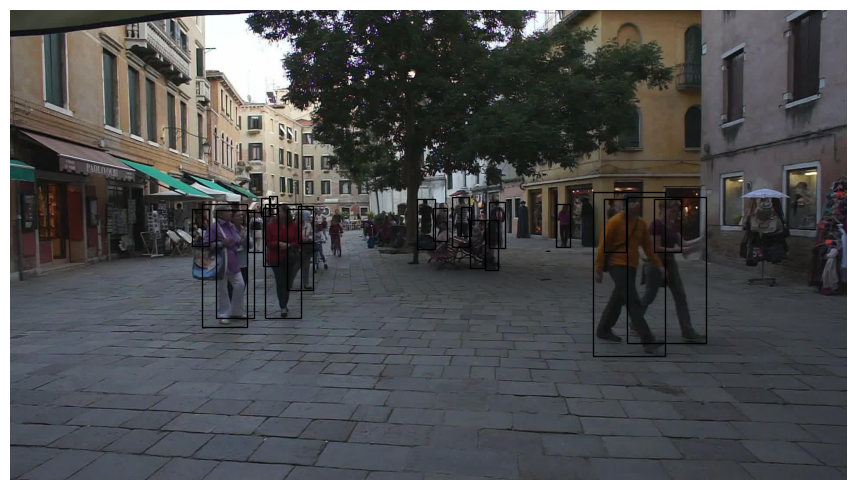

In [10]:
seq_name = 'MOT16-02'
data_dir = os.path.join(root_dir, 'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True) # Get a coffee.

for seq in sequences:
    for i, frame in enumerate(seq):
        img = frame['img']
        
        dpi = 96
        fig, ax = plt.subplots(1, dpi=dpi)

        img = img.mul(255).permute(1, 2, 0).byte().numpy()
        width, height, _ = img.shape
          
        ax.imshow(img, cmap='gray')
        fig.set_size_inches(width / dpi, height / dpi)

        if 'gt' in frame:
            gt = frame['gt']
            for gt_id, box in gt.items():
                rect = plt.Rectangle(
                  (box[0], box[1]),
                  box[2] - box[0],
                  box[3] - box[1],
                  fill=False,
                  linewidth=1.0)
                ax.add_patch(rect)

        plt.axis('off')
        plt.show()
        break

# Object detector

We provide you with an object detector pretrained on the MOT challenge training set for this exercise.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

In [11]:
if using_local:
    !ls "cv3dst_exercise/models"
else:
    !ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/models"

faster_rcnn_fpn.model



## Configuration

In [12]:
obj_detect_model_file = os.path.join(root_dir, 'models/faster_rcnn_fpn.model')
obj_detect_nms_thresh = 0.3

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(obj_detect_model_file,
                                   map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect.to(device)

cuda


FRCNN_FPN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu)

In [14]:
dataset_test = MOT16ObjDetect(os.path.join(root_dir, 'data/MOT16/train'),
                              obj_detect_transforms(train=False))
def collate_fn(batch):
    return tuple(zip(*batch))
data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=collate_fn)

# evaluate_obj_detect(obj_detect, data_loader_test)

# Multi-object tracking

We provide you with a simple baseline tracker which predicts object detections for each frame and generates tracks by assigning current detections to previous detections via Intersection over Union.

## Configuration

In [16]:
seed = 12345
seq_name = 'MOT16-reid'  # We recommend to use this subset.
data_dir = os.path.join(root_dir, 'data/MOT16')
output_dir = os.path.join(root_dir, 'output')

## Setup

In [17]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

# dataset
sequences = MOT16Sequences(seq_name, data_dir)

In [18]:
# Old Tracker
class TrackerIoUAssignment(Tracker):

    def data_association(self, boxes, scores):
        if self.tracks:
            track_ids = [t.id for t in self.tracks]
            track_boxes = np.stack([t.box.numpy() for t in self.tracks], axis=0)
            
            distance = mm.distances.iou_matrix(track_boxes, boxes.numpy(), max_iou=0.5)

            # update existing tracks
            remove_track_ids = []
            for t, dist in zip(self.tracks, distance):
                if np.isnan(dist).all():
                    remove_track_ids.append(t.id)
                else:
                    match_id = np.nanargmin(dist)
                    t.box = boxes[match_id]
            self.tracks = [t for t in self.tracks
                           if t.id not in remove_track_ids]

            # add new tracks
            new_boxes = []
            new_scores = []
            for i, dist in enumerate(np.transpose(distance)):
                if np.isnan(dist).all():
                    new_boxes.append(boxes[i])
                    new_scores.append(scores[i])
            self.add(new_boxes, new_scores)

        else:
            self.add(boxes, scores)

## Exercise Part I - Hungarian IoU Tracker

The previous tracker `TrackerIoUAssignment` will build a cost matrix as follows: Given $n$ tracks and $m$ detected boxes, the result will be a $n\times m$ matrix with each being $1 - IoU(track, box)$ for $IoU >= 0.5$ and `np.nan` otherwise. Then, each track is extended with the best box in terms of costs. All predicted boxes, that don't overlap, i.e., $IoU < 0.5$, at all with the tracks start new tracks.

This Tracker has several issues. Can you spot them?

One, of the issues is that this tracker does not ensure unique matching. Therefore, your task is to implement a tracker that uses hungarian matching. In the following, we provide a code fragment that you can use.

In [19]:
_UNMATCHED_COST = 255.0
class HungarianIoUTracker(Tracker):

    def data_association(self, boxes, scores):
        if self.tracks:
            track_ids = [t.id for t in self.tracks]
            track_boxes = np.stack([t.box.numpy() for t in self.tracks], axis=0)
            
            # Build cost matrix.
            distance = mm.distances.iou_matrix(track_boxes, boxes.numpy(), max_iou=0.5)

            # Set all unmatched costs to _UNMATCHED_COST.
            distance = np.where(np.isnan(distance), _UNMATCHED_COST, distance)

            # Perform Hungarian matching.
            row_idx, col_idx = linear_assignment(distance)

            # row_idx and col_idx are indices into track_boxes and boxes.
            # row_idx[i] and col_idx[i] define a match.
            # distance[row_idx[i], col_idx[i]] define the cost for that matching.

            # TODO: Update existing tracks and remove unmatched tracks.
            # Reminder: If the costs are equal to _UNMATCHED_COST, it's not a 
            # match. Be careful with override self.tracks, as past tracks will 
            # be gone.
            remove_track_ids = [track_ids[r] for r in range(len(track_ids)) if r not in row_idx]
            for i in range(len(row_idx)):
                r_id = row_idx[i]
                c_id = col_idx[i]
                if distance[r_id, c_id] == _UNMATCHED_COST:
                    remove_track_ids.append(track_ids[r_id])
                else:
                    self.tracks[r_id].box = boxes[c_id]
            self.tracks = [t for t in self.tracks
                           if t.id not in remove_track_ids]


            # TODO: Add new tracks.
            new_boxes = []  # <-- needs to be filled.
            new_scores = [] # <-- needs to be filled.
            #ids of boxes assigned to unmtach; it does not exist a better one and therefore is new track
            for i in range(len(col_idx)):
                r_id = row_idx[i]
                c_id = col_idx[i]
                if distance[r_id, c_id] == _UNMATCHED_COST:
                    new_boxes.append(boxes[c_id])
                    new_scores.append(scores[c_id])
            
            #ids of boxes that were not assigned; must be new track
            untracked_boxes_indices = [c for c in range(len(boxes)) if c not in col_idx]
            for c in untracked_boxes_indices:
                new_boxes.append(boxes[c])
                new_scores.append(scores[c])
                
  
            self.add(new_boxes, new_scores)
        else:
            # No tracks exist.
            self.add(boxes, scores)

*Optionally*: Whenever an object is occluded it will disappear. In the current setup, the re-appearing object will cause a new track to spawn. Modify the tracker to keep inactive frames in the memory for a number of frames. The track list `self.tracks` is only allowed to contain active tracks, i.e., tracks that are present in the current frame.

## Run tracker

In [20]:
# Old Tracker
# tracker = TrackerIoUAssignment(obj_detect)
# New tracker:
tracker = HungarianIoUTracker(obj_detect)

In [21]:
time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Tracking: MOT16-02


  0%|          | 0/600 [00:00<?, ?it/s]

Tracks found: 242
Runtime for MOT16-02: 117.5 s.
Writing predictions to: cv3dst_exercise/output/MOT16-02.txt
Tracking: MOT16-05


  0%|          | 0/837 [00:00<?, ?it/s]

Tracks found: 270
Runtime for MOT16-05: 106.3 s.
Writing predictions to: cv3dst_exercise/output/MOT16-05.txt
Tracking: MOT16-09


  0%|          | 0/525 [00:00<?, ?it/s]

Tracks found: 84
Runtime for MOT16-09: 103.0 s.
Writing predictions to: cv3dst_exercise/output/MOT16-09.txt
Tracking: MOT16-11


  0%|          | 0/900 [00:00<?, ?it/s]

Tracks found: 175
Runtime for MOT16-11: 176.6 s.
Writing predictions to: cv3dst_exercise/output/MOT16-11.txt
Runtime for all sequences: 503.4 s.
          IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT ML   FP    FN IDs   FM  MOTA  MOTP
MOT16-02 38.9% 55.2% 30.0% 52.2% 96.2%  62  11  38 13  383  8875 242  215 48.9% 0.096
MOT16-05 55.3% 65.4% 47.8% 68.8% 94.1% 133  55  66 12  299  2160 194  150 61.6% 0.142
MOT16-09 50.0% 61.9% 42.0% 66.4% 97.8%  26  13  12  1   81  1791  76   77 63.4% 0.082
MOT16-11 61.6% 67.9% 56.3% 80.2% 96.6%  75  43  25  7  266  1869  98   88 76.3% 0.083
OVERALL  49.2% 61.8% 40.8% 63.5% 96.1% 296 122 141 33 1029 14695 610  530 59.4% 0.099


## Hungarian Tracker Results

As a point of reference, you should roughly get the following scores or better:

            IDF1   IDP   IDR   Rcll  Prcn  GT  MT  PT ML  FP   FN IDs   FM  MOTA  MOTP
    MOT16-02 30.1% 59.0% 20.2% 33.8% 99.1%  62  4  26 32  60 12298  85   91 33.0% 0.077
    MOT16-05 48.8% 59.8% 41.2% 60.5% 87.8% 133 37  68 28 582  2729 105  110 50.6% 0.147
    MOT16-09 44.5% 60.8% 35.2% 56.2% 97.1%  26  8  15  3  89  2334  44   65 53.7% 0.091
    MOT16-11 48.1% 63.3% 38.7% 59.0% 96.6%  75 18  31 26 197  3865  29   41 56.6% 0.081
    OVERALL  40.3% 60.7% 30.1% 47.3% 95.4% 296 67 140 89 928 21226 263  307 44.3% 0.095

## Visualize tracking results

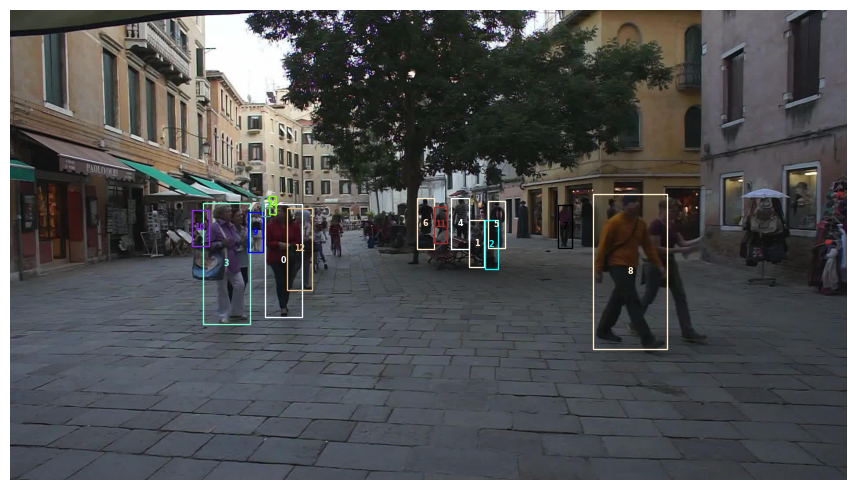

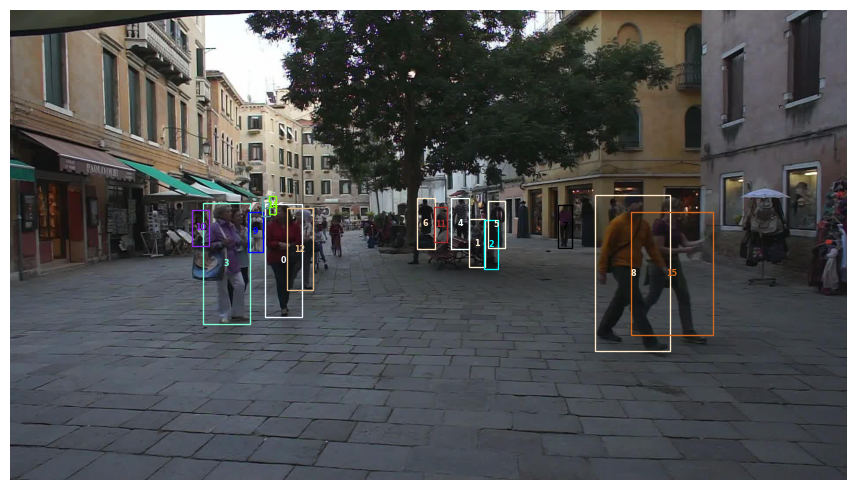

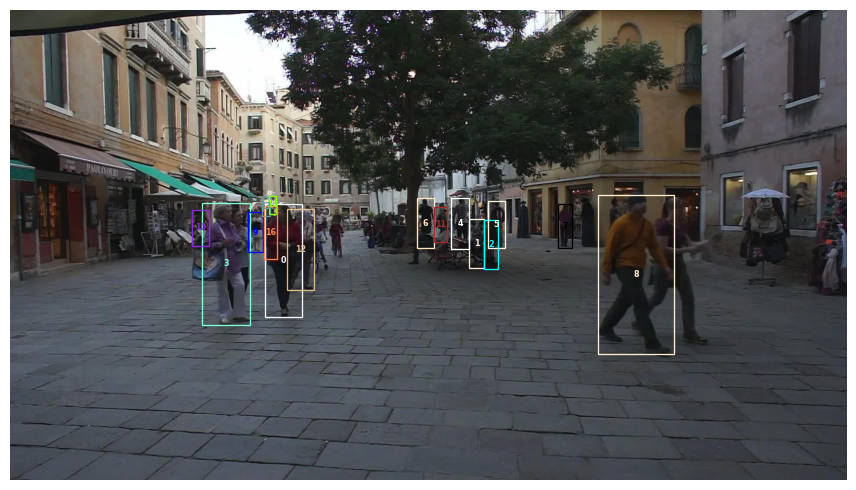

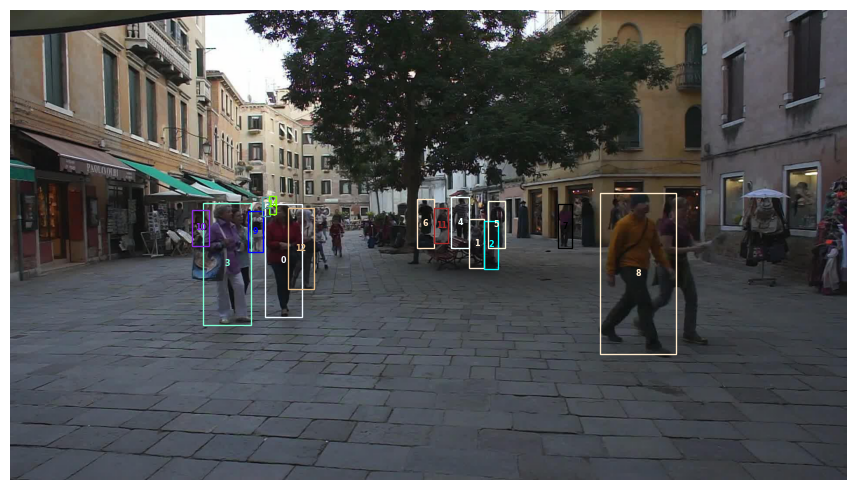

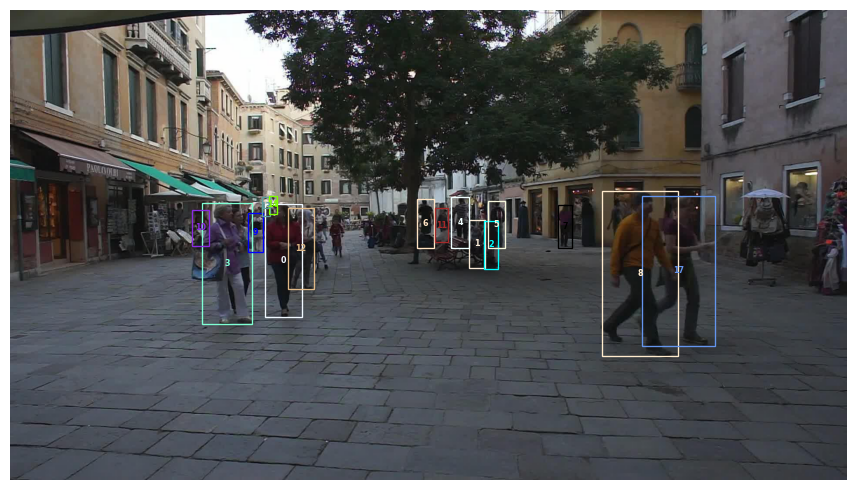

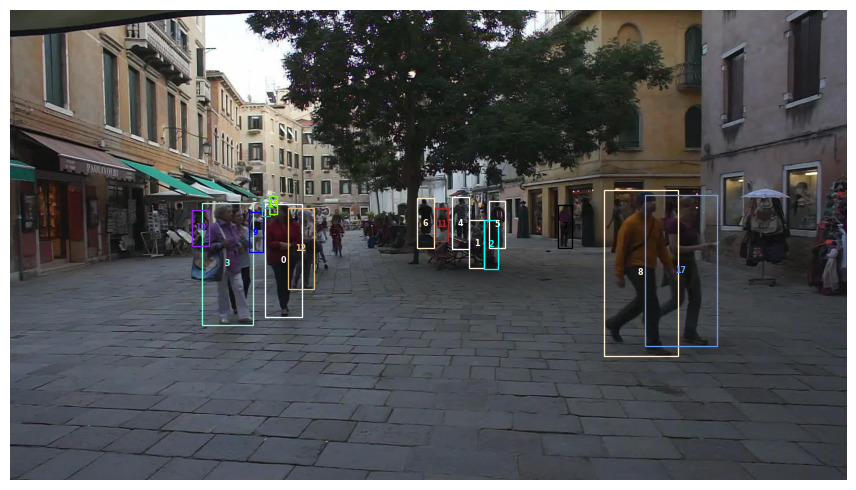

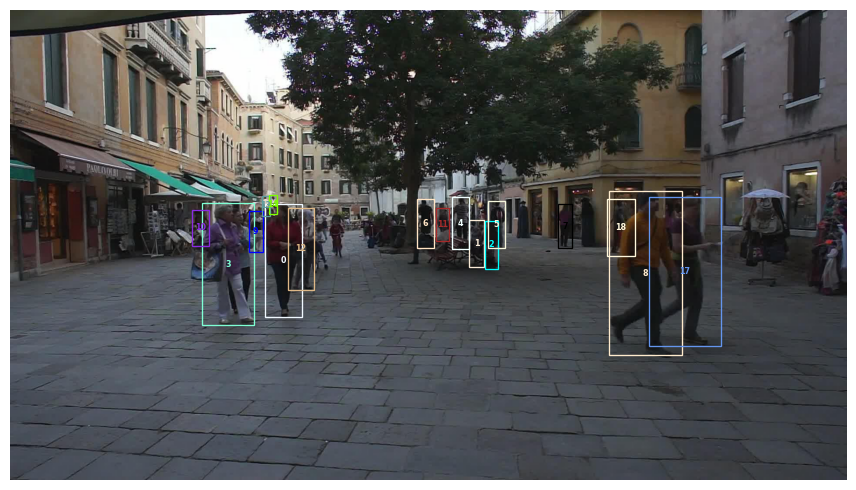

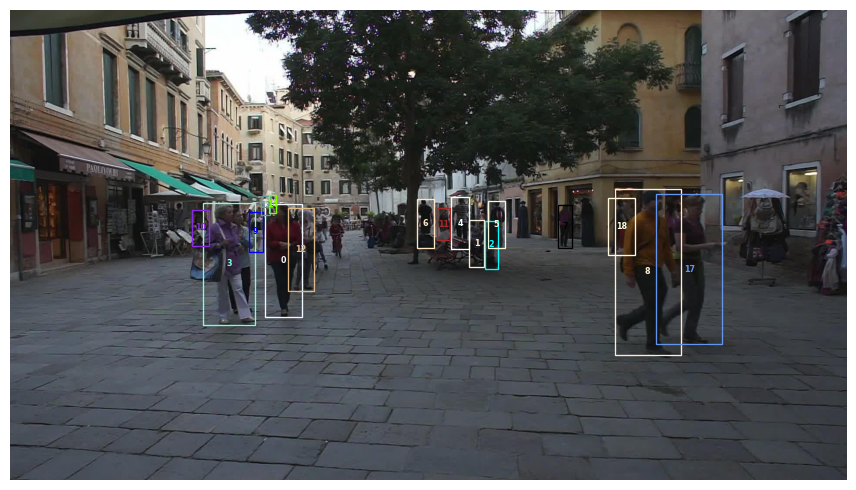

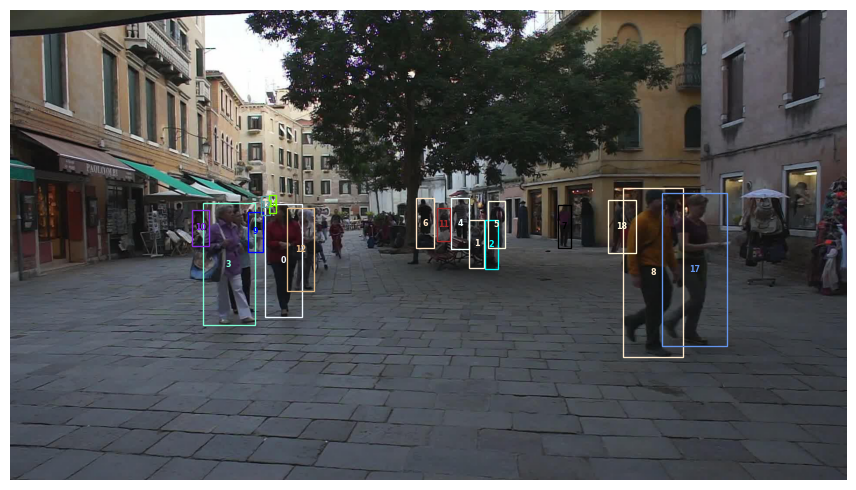

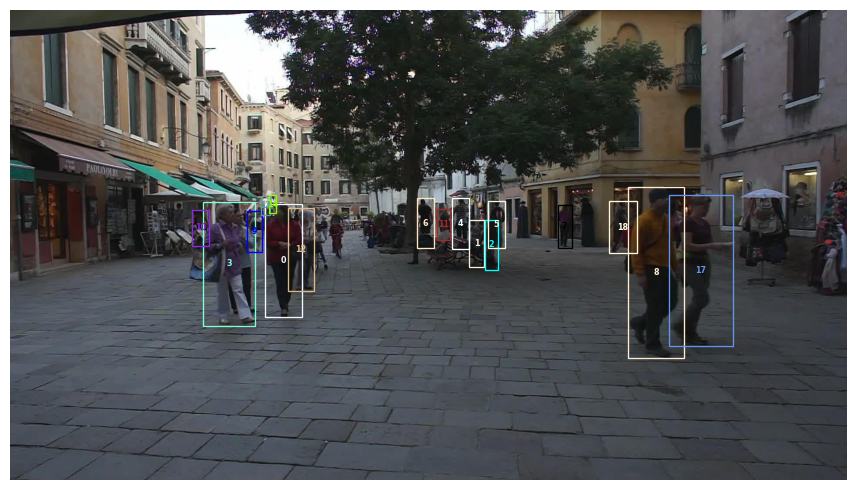

In [22]:
plot_sequence(results_seq['MOT16-02'],
              [s for s in sequences if str(s) == 'MOT16-02'][0],
              first_n_frames=10)

# Exercise Part II - Training a ReID Network

For this part of the exercise, you will train a simple ReID network on the Market data. For this exercise, we will use a ResNet34/ResNet50 neural network that extracts features from an input image. In the following, we will provide the code for setting up the training process.

In [23]:
# Load helper code
from market.datamanager import ImageDataManager
from market.models import build_model
from market import utils
from market import metrics

import torch
from torch.nn import functional as F

Next, we create the the DataManager for the Market dataset that will provide the train and test sets:

In [24]:
datamanager = ImageDataManager(root='.', height=256,width=128, batch_size_train=32, 
                               workers=2, transforms=['random_flip', 'random_crop'])
train_loader = datamanager.train_loader
test_loader = datamanager.test_loader

Building train transforms ...
+ resize to 256x128
+ random flip
+ random crop (enlarge to 288x144 and crop 256x128)
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
=> Loading train (source) dataset
=> Loaded Market1501
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gallery  |   751 |    15913 |         6
  ----------------------------------------
=> Loading test (target) dataset
=> Loaded Market1501
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gal

Now, let's create a resnet34 model and move it to the GPU.

In [25]:
model = build_model('resnet34', datamanager.num_train_pids, loss='softmax', pretrained=True)
model = model.cuda()

trainable_params = model.parameters()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

For training the network, we now need to choose an optimizer and learning rate scheduler.

In [26]:
optimizer = torch.optim.Adam(trainable_params, lr=0.0003, # <--- Feel free to play around with the lr parameter.
                             weight_decay=5e-4, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)

The network will be trained on a cross-entropy loss, i.e., the network needs to classify each image to it's identity class. For $n$ different people, we will have $n$ different classes.

During evaluation, we ignore the last classification layer and work on the extracted $feat$-dimensional features. This feature vector should be very similar for the same instance, and not similar for different instances.

In the following, you have to implement two distance measurements:
- Euclidian squared distance.
- Cosine similarity.

You are not allowed to change the interface of the function. Please have a look at the [Pytorch documentation](https://pytorch.org/docs/stable/index.html).

In [27]:
def euclidean_squared_distance(input1, input2):
    """Computes euclidean squared distance.
    Args:
        input1 (torch.Tensor): 2-D feature matrix (m x feat).
        input2 (torch.Tensor): 2-D feature matrix (n x feat).
    Returns:
        torch.Tensor: distance matrix (m x n).
    """
    m, n = input1.size(0), input2.size(0)
    # TASK: Compute a m x n tensor that contains the euclidian distance between
    # all m elements to all n elements. Each element is a feat-D vector.
    distmat =torch.cdist(input1, input2)
    distmat = distmat**2
    return distmat

In [28]:
def cosine_distance(input1, input2):
    """Computes cosine distance.
    Args:
        input1 (torch.Tensor): 2-D feature matrix (m x feat).
        input2 (torch.Tensor): 2-D feature matrix (n x feat).
    Returns:
        torch.Tensor: distance matrix (m x n).
    """
    # TASK: Compute a m x n tensor that contains the cosine similarity between
    # all m elements to all n elements. Each element is a feat-D vector.
    # Hint: The provided feature vectors are NOT normalized. For normalized features,
    # the dot-product is equal to the cosine similariy.
    in1 = torch.nn.functional.normalize(input1)
    in2 = torch.nn.functional.normalize(input2)
    cosine_similarity = torch.matmul(in1, in2.T)
    distmat = 1 - cosine_similarity
    return distmat

With the implemented distance measure, we can now implement the evaluation function. For this exercise, we did this already. We extract features for the query set and for the gallery set and then build a distance matrix based on your implemented distance measure.

In [29]:
# TASK: Needs to be set to one of the distance measurements, try both.
metric_fn = cosine_distance  
def evaluate(model, test_loader, ranks=[1, 5, 10, 20]):
    with torch.no_grad():
        model.eval()
        print('Extracting features from query set...')
        q_feat, q_pids, q_camids = utils.extract_features(model, test_loader['query'])
        print('Done, obtained {}-by-{} matrix'.format(q_feat.size(0), q_feat.size(1)))

        print('Extracting features from gallery set ...')
        g_feat, g_pids, g_camids = utils.extract_features(model, test_loader['gallery'])
        print('Done, obtained {}-by-{} matrix'.format(g_feat.size(0), g_feat.size(1)))
        
        distmat = metrics.compute_distance_matrix(q_feat, g_feat, metric_fn=metric_fn)
        distmat = distmat.numpy()

        print('Computing CMC and mAP ...')
        cmc, mAP = metrics.eval_market1501(
            distmat,
            q_pids,
            g_pids,
            q_camids,
            g_camids,
            max_rank=50
        )

        print('** Results **')
        print('mAP: {:.1%}'.format(mAP))
        print('CMC curve')
        for r in ranks:
            print('Rank-{:<3}: {:.1%}'.format(r, cmc[r - 1]))
        return cmc[0], mAP

Finally, we can implement the training logic. For this exercise we have done this already. Feel free, to play around with the training epoch.

In [30]:
MAX_EPOCH = 30
EPOCH_EVAL_FREQ = 5
PRINT_FREQ = 10

num_batches = len(train_loader)
criterion = torch.nn.CrossEntropyLoss() # <--- We start by using CrossEntropy loss.

for epoch in range(MAX_EPOCH):
    losses = utils.MetricMeter()
    batch_time = utils.AverageMeter()
    end = time.time()
    model.train()
    for batch_idx, data in enumerate(train_loader):
        # Predict output.
        imgs, pids = data['img'].cuda(), data['pid'].cuda()
        output = model(imgs)
        # Compute loss.
        loss = criterion(output, pids)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_time.update(time.time() - end)
        losses.update({'Loss': loss})
        if (batch_idx + 1) % PRINT_FREQ == 0:
            utils.print_statistics(batch_idx, num_batches, epoch, MAX_EPOCH, batch_time, losses)
        end = time.time()
        
    if (epoch + 1) % EPOCH_EVAL_FREQ == 0 or epoch == MAX_EPOCH - 1:
        rank1, mAP = evaluate(model, test_loader)
        print('Epoch {0}/{1}: Rank1: {rank}, mAP: {map}'.format(
                    epoch + 1, MAX_EPOCH, rank=rank1, map=mAP))

epoch: [1/30][10/404]	time 0.144 (0.167)	eta 0:33:47	Loss 6.7458 (6.6840)	
epoch: [1/30][20/404]	time 0.144 (0.156)	eta 0:31:29	Loss 6.4245 (6.6814)	
epoch: [1/30][30/404]	time 0.155 (0.153)	eta 0:30:47	Loss 6.6165 (6.7087)	
epoch: [1/30][40/404]	time 0.144 (0.152)	eta 0:30:32	Loss 6.5384 (6.7024)	
epoch: [1/30][50/404]	time 0.145 (0.150)	eta 0:30:14	Loss 7.0062 (6.6880)	
epoch: [1/30][60/404]	time 0.160 (0.151)	eta 0:30:24	Loss 6.2417 (6.6631)	
epoch: [1/30][70/404]	time 0.153 (0.152)	eta 0:30:29	Loss 6.7020 (6.6367)	
epoch: [1/30][80/404]	time 0.159 (0.152)	eta 0:30:32	Loss 5.9832 (6.6107)	
epoch: [1/30][90/404]	time 0.145 (0.152)	eta 0:30:33	Loss 6.3504 (6.5777)	
epoch: [1/30][100/404]	time 0.145 (0.152)	eta 0:30:23	Loss 6.3743 (6.5489)	
epoch: [1/30][110/404]	time 0.145 (0.151)	eta 0:30:14	Loss 6.0189 (6.5055)	
epoch: [1/30][120/404]	time 0.145 (0.151)	eta 0:30:07	Loss 5.6799 (6.4669)	
epoch: [1/30][130/404]	time 0.146 (0.150)	eta 0:30:01	Loss 5.7778 (6.4307)	
epoch: [1/30][140/404

epoch: [3/30][300/404]	time 0.152 (0.152)	eta 0:27:58	Loss 1.1155 (1.1578)	
epoch: [3/30][310/404]	time 0.152 (0.152)	eta 0:27:57	Loss 0.8493 (1.1519)	
epoch: [3/30][320/404]	time 0.168 (0.153)	eta 0:27:56	Loss 1.3549 (1.1473)	
epoch: [3/30][330/404]	time 0.153 (0.153)	eta 0:27:55	Loss 0.7731 (1.1391)	
epoch: [3/30][340/404]	time 0.152 (0.153)	eta 0:27:53	Loss 1.2523 (1.1358)	
epoch: [3/30][350/404]	time 0.153 (0.153)	eta 0:27:52	Loss 0.9495 (1.1328)	
epoch: [3/30][360/404]	time 0.152 (0.153)	eta 0:27:53	Loss 1.0014 (1.1277)	
epoch: [3/30][370/404]	time 0.153 (0.153)	eta 0:27:52	Loss 0.8312 (1.1228)	
epoch: [3/30][380/404]	time 0.153 (0.153)	eta 0:27:51	Loss 1.1076 (1.1194)	
epoch: [3/30][390/404]	time 0.152 (0.153)	eta 0:27:49	Loss 0.6432 (1.1142)	
epoch: [3/30][400/404]	time 0.153 (0.153)	eta 0:27:48	Loss 0.9457 (1.1093)	
epoch: [4/30][10/404]	time 0.153 (0.162)	eta 0:29:27	Loss 0.8894 (0.7759)	
epoch: [4/30][20/404]	time 0.153 (0.158)	eta 0:28:40	Loss 0.5926 (0.7840)	
epoch: [4/30][

epoch: [6/30][140/404]	time 0.149 (0.151)	eta 0:25:04	Loss 0.5632 (0.3869)	
epoch: [6/30][150/404]	time 0.149 (0.151)	eta 0:25:02	Loss 0.2648 (0.3832)	
epoch: [6/30][160/404]	time 0.150 (0.151)	eta 0:24:59	Loss 0.2443 (0.3800)	
epoch: [6/30][170/404]	time 0.150 (0.151)	eta 0:24:57	Loss 0.6858 (0.3825)	
epoch: [6/30][180/404]	time 0.150 (0.151)	eta 0:24:55	Loss 0.4928 (0.3836)	
epoch: [6/30][190/404]	time 0.150 (0.151)	eta 0:24:53	Loss 0.2921 (0.3843)	
epoch: [6/30][200/404]	time 0.150 (0.151)	eta 0:24:51	Loss 0.4182 (0.3839)	
epoch: [6/30][210/404]	time 0.150 (0.151)	eta 0:24:49	Loss 0.2788 (0.3823)	
epoch: [6/30][220/404]	time 0.150 (0.151)	eta 0:24:47	Loss 0.4271 (0.3835)	
epoch: [6/30][230/404]	time 0.150 (0.151)	eta 0:24:45	Loss 0.4185 (0.3845)	
epoch: [6/30][240/404]	time 0.150 (0.151)	eta 0:24:44	Loss 0.4250 (0.3834)	
epoch: [6/30][250/404]	time 0.150 (0.150)	eta 0:24:42	Loss 0.3512 (0.3806)	
epoch: [6/30][260/404]	time 0.150 (0.150)	eta 0:24:40	Loss 0.4038 (0.3800)	
epoch: [6/30

epoch: [9/30][30/404]	time 0.153 (0.159)	eta 0:23:29	Loss 0.1586 (0.2362)	
epoch: [9/30][40/404]	time 0.153 (0.158)	eta 0:23:20	Loss 0.1675 (0.2259)	
epoch: [9/30][50/404]	time 0.153 (0.158)	eta 0:23:16	Loss 0.1234 (0.2257)	
epoch: [9/30][60/404]	time 0.153 (0.158)	eta 0:23:12	Loss 0.2203 (0.2235)	
epoch: [9/30][70/404]	time 0.161 (0.158)	eta 0:23:10	Loss 0.4364 (0.2306)	
epoch: [9/30][80/404]	time 0.159 (0.157)	eta 0:23:06	Loss 0.2839 (0.2298)	
epoch: [9/30][90/404]	time 0.160 (0.157)	eta 0:23:04	Loss 0.2774 (0.2281)	
epoch: [9/30][100/404]	time 0.156 (0.157)	eta 0:23:01	Loss 0.2185 (0.2257)	
epoch: [9/30][110/404]	time 0.155 (0.157)	eta 0:22:58	Loss 0.1636 (0.2222)	
epoch: [9/30][120/404]	time 0.154 (0.157)	eta 0:22:56	Loss 0.1310 (0.2252)	
epoch: [9/30][130/404]	time 0.156 (0.157)	eta 0:22:55	Loss 0.2774 (0.2248)	
epoch: [9/30][140/404]	time 0.154 (0.157)	eta 0:22:53	Loss 0.2768 (0.2262)	
epoch: [9/30][150/404]	time 0.157 (0.157)	eta 0:22:51	Loss 0.1776 (0.2230)	
epoch: [9/30][160/4

epoch: [11/30][260/404]	time 0.150 (0.151)	eta 0:19:43	Loss 0.3173 (0.1965)	
epoch: [11/30][270/404]	time 0.163 (0.152)	eta 0:19:43	Loss 0.1732 (0.1968)	
epoch: [11/30][280/404]	time 0.151 (0.152)	eta 0:19:44	Loss 0.0924 (0.1966)	
epoch: [11/30][290/404]	time 0.151 (0.152)	eta 0:19:43	Loss 0.3469 (0.1954)	
epoch: [11/30][300/404]	time 0.151 (0.152)	eta 0:19:41	Loss 0.1210 (0.1945)	
epoch: [11/30][310/404]	time 0.161 (0.152)	eta 0:19:41	Loss 0.0704 (0.1944)	
epoch: [11/30][320/404]	time 0.151 (0.152)	eta 0:19:39	Loss 0.1194 (0.1943)	
epoch: [11/30][330/404]	time 0.165 (0.152)	eta 0:19:38	Loss 0.1208 (0.1943)	
epoch: [11/30][340/404]	time 0.151 (0.152)	eta 0:19:38	Loss 0.1595 (0.1947)	
epoch: [11/30][350/404]	time 0.151 (0.152)	eta 0:19:36	Loss 0.2517 (0.1951)	
epoch: [11/30][360/404]	time 0.151 (0.152)	eta 0:19:34	Loss 0.4343 (0.1960)	
epoch: [11/30][370/404]	time 0.151 (0.152)	eta 0:19:33	Loss 0.1511 (0.1963)	
epoch: [11/30][380/404]	time 0.153 (0.152)	eta 0:19:32	Loss 0.2621 (0.1973)	

epoch: [14/30][130/404]	time 0.153 (0.157)	eta 0:17:40	Loss 0.2347 (0.1472)	
epoch: [14/30][140/404]	time 0.161 (0.157)	eta 0:17:38	Loss 0.1440 (0.1461)	
epoch: [14/30][150/404]	time 0.154 (0.157)	eta 0:17:36	Loss 0.1396 (0.1451)	
epoch: [14/30][160/404]	time 0.159 (0.157)	eta 0:17:34	Loss 0.1371 (0.1464)	
epoch: [14/30][170/404]	time 0.157 (0.157)	eta 0:17:32	Loss 0.1764 (0.1448)	
epoch: [14/30][180/404]	time 0.159 (0.157)	eta 0:17:31	Loss 0.0828 (0.1451)	
epoch: [14/30][190/404]	time 0.160 (0.157)	eta 0:17:29	Loss 0.1188 (0.1467)	
epoch: [14/30][200/404]	time 0.153 (0.157)	eta 0:17:27	Loss 0.0837 (0.1467)	
epoch: [14/30][210/404]	time 0.157 (0.157)	eta 0:17:25	Loss 0.1510 (0.1465)	
epoch: [14/30][220/404]	time 0.158 (0.157)	eta 0:17:24	Loss 0.1438 (0.1459)	
epoch: [14/30][230/404]	time 0.157 (0.157)	eta 0:17:22	Loss 0.0824 (0.1443)	
epoch: [14/30][240/404]	time 0.159 (0.157)	eta 0:17:20	Loss 0.1647 (0.1437)	
epoch: [14/30][250/404]	time 0.160 (0.157)	eta 0:17:19	Loss 0.0835 (0.1442)	

epoch: [16/30][360/404]	time 0.151 (0.150)	eta 0:14:14	Loss 0.1557 (0.1486)	
epoch: [16/30][370/404]	time 0.151 (0.150)	eta 0:14:13	Loss 0.1443 (0.1486)	
epoch: [16/30][380/404]	time 0.151 (0.150)	eta 0:14:11	Loss 0.2351 (0.1486)	
epoch: [16/30][390/404]	time 0.151 (0.150)	eta 0:14:10	Loss 0.1354 (0.1483)	
epoch: [16/30][400/404]	time 0.151 (0.150)	eta 0:14:09	Loss 0.1686 (0.1488)	
epoch: [17/30][10/404]	time 0.151 (0.160)	eta 0:15:05	Loss 0.1287 (0.1381)	
epoch: [17/30][20/404]	time 0.152 (0.156)	eta 0:14:38	Loss 0.1019 (0.1187)	
epoch: [17/30][30/404]	time 0.151 (0.154)	eta 0:14:28	Loss 0.0636 (0.1063)	
epoch: [17/30][40/404]	time 0.151 (0.154)	eta 0:14:23	Loss 0.0803 (0.0990)	
epoch: [17/30][50/404]	time 0.152 (0.153)	eta 0:14:19	Loss 0.1048 (0.0977)	
epoch: [17/30][60/404]	time 0.152 (0.153)	eta 0:14:16	Loss 0.0881 (0.0958)	
epoch: [17/30][70/404]	time 0.152 (0.153)	eta 0:14:14	Loss 0.0934 (0.0988)	
epoch: [17/30][80/404]	time 0.152 (0.153)	eta 0:14:12	Loss 0.0490 (0.1001)	
epoch: 

epoch: [19/30][230/404]	time 0.157 (0.157)	eta 0:12:06	Loss 0.2313 (0.1472)	
epoch: [19/30][240/404]	time 0.159 (0.157)	eta 0:12:04	Loss 0.2142 (0.1487)	
epoch: [19/30][250/404]	time 0.156 (0.157)	eta 0:12:02	Loss 0.3072 (0.1503)	
epoch: [19/30][260/404]	time 0.153 (0.157)	eta 0:12:01	Loss 0.1660 (0.1515)	
epoch: [19/30][270/404]	time 0.153 (0.157)	eta 0:11:59	Loss 0.1419 (0.1517)	
epoch: [19/30][280/404]	time 0.153 (0.157)	eta 0:11:58	Loss 0.2642 (0.1537)	
epoch: [19/30][290/404]	time 0.159 (0.157)	eta 0:11:56	Loss 0.1323 (0.1558)	
epoch: [19/30][300/404]	time 0.155 (0.157)	eta 0:11:54	Loss 0.2202 (0.1582)	
epoch: [19/30][310/404]	time 0.153 (0.157)	eta 0:11:53	Loss 0.2534 (0.1596)	
epoch: [19/30][320/404]	time 0.159 (0.157)	eta 0:11:51	Loss 0.2476 (0.1613)	
epoch: [19/30][330/404]	time 0.153 (0.157)	eta 0:11:49	Loss 0.0821 (0.1634)	
epoch: [19/30][340/404]	time 0.160 (0.157)	eta 0:11:48	Loss 0.1652 (0.1632)	
epoch: [19/30][350/404]	time 0.157 (0.157)	eta 0:11:46	Loss 0.2720 (0.1640)	

epoch: [22/30][60/404]	time 0.152 (0.153)	eta 0:09:08	Loss 0.2097 (0.1239)	
epoch: [22/30][70/404]	time 0.152 (0.153)	eta 0:09:06	Loss 0.1251 (0.1239)	
epoch: [22/30][80/404]	time 0.152 (0.153)	eta 0:09:04	Loss 0.1890 (0.1245)	
epoch: [22/30][90/404]	time 0.152 (0.153)	eta 0:09:02	Loss 0.0660 (0.1232)	
epoch: [22/30][100/404]	time 0.152 (0.153)	eta 0:09:00	Loss 0.1032 (0.1257)	
epoch: [22/30][110/404]	time 0.152 (0.153)	eta 0:08:58	Loss 0.2077 (0.1276)	
epoch: [22/30][120/404]	time 0.152 (0.153)	eta 0:08:57	Loss 0.1383 (0.1298)	
epoch: [22/30][130/404]	time 0.152 (0.153)	eta 0:08:55	Loss 0.1873 (0.1298)	
epoch: [22/30][140/404]	time 0.152 (0.153)	eta 0:08:53	Loss 0.0840 (0.1297)	
epoch: [22/30][150/404]	time 0.152 (0.153)	eta 0:08:52	Loss 0.1453 (0.1275)	
epoch: [22/30][160/404]	time 0.152 (0.153)	eta 0:08:50	Loss 0.1075 (0.1285)	
epoch: [22/30][170/404]	time 0.152 (0.153)	eta 0:08:49	Loss 0.1456 (0.1269)	
epoch: [22/30][180/404]	time 0.152 (0.153)	eta 0:08:47	Loss 0.0663 (0.1257)	
epo

epoch: [24/30][330/404]	time 0.153 (0.157)	eta 0:06:32	Loss 0.1283 (0.1235)	
epoch: [24/30][340/404]	time 0.156 (0.157)	eta 0:06:30	Loss 0.1784 (0.1240)	
epoch: [24/30][350/404]	time 0.154 (0.157)	eta 0:06:29	Loss 0.1386 (0.1257)	
epoch: [24/30][360/404]	time 0.161 (0.157)	eta 0:06:27	Loss 0.2034 (0.1272)	
epoch: [24/30][370/404]	time 0.156 (0.157)	eta 0:06:26	Loss 0.4039 (0.1298)	
epoch: [24/30][380/404]	time 0.159 (0.157)	eta 0:06:24	Loss 0.1545 (0.1306)	
epoch: [24/30][390/404]	time 0.155 (0.157)	eta 0:06:22	Loss 0.1411 (0.1329)	
epoch: [24/30][400/404]	time 0.154 (0.157)	eta 0:06:21	Loss 0.4086 (0.1347)	
epoch: [25/30][10/404]	time 0.160 (0.166)	eta 0:06:40	Loss 0.1155 (0.1599)	
epoch: [25/30][20/404]	time 0.154 (0.162)	eta 0:06:28	Loss 0.2608 (0.1597)	
epoch: [25/30][30/404]	time 0.159 (0.160)	eta 0:06:23	Loss 0.0964 (0.1521)	
epoch: [25/30][40/404]	time 0.158 (0.159)	eta 0:06:19	Loss 0.1183 (0.1448)	
epoch: [25/30][50/404]	time 0.157 (0.159)	eta 0:06:16	Loss 0.1234 (0.1428)	
epoc

epoch: [27/30][160/404]	time 0.153 (0.153)	eta 0:03:42	Loss 0.0675 (0.1168)	
epoch: [27/30][170/404]	time 0.152 (0.153)	eta 0:03:40	Loss 0.0554 (0.1137)	
epoch: [27/30][180/404]	time 0.152 (0.153)	eta 0:03:39	Loss 0.0301 (0.1112)	
epoch: [27/30][190/404]	time 0.152 (0.153)	eta 0:03:37	Loss 0.0338 (0.1082)	
epoch: [27/30][200/404]	time 0.152 (0.153)	eta 0:03:36	Loss 0.0702 (0.1060)	
epoch: [27/30][210/404]	time 0.153 (0.153)	eta 0:03:34	Loss 0.0540 (0.1040)	
epoch: [27/30][220/404]	time 0.153 (0.153)	eta 0:03:33	Loss 0.1218 (0.1023)	
epoch: [27/30][230/404]	time 0.152 (0.153)	eta 0:03:31	Loss 0.0386 (0.1008)	
epoch: [27/30][240/404]	time 0.153 (0.153)	eta 0:03:30	Loss 0.0944 (0.1009)	
epoch: [27/30][250/404]	time 0.153 (0.153)	eta 0:03:28	Loss 0.1036 (0.1004)	
epoch: [27/30][260/404]	time 0.153 (0.153)	eta 0:03:27	Loss 0.0419 (0.1001)	
epoch: [27/30][270/404]	time 0.152 (0.153)	eta 0:03:25	Loss 0.0748 (0.1012)	
epoch: [27/30][280/404]	time 0.152 (0.153)	eta 0:03:23	Loss 0.0921 (0.1011)	

epoch: [30/30][30/404]	time 0.161 (0.160)	eta 0:00:59	Loss 0.1049 (0.1282)	
epoch: [30/30][40/404]	time 0.153 (0.159)	eta 0:00:57	Loss 0.1167 (0.1269)	
epoch: [30/30][50/404]	time 0.158 (0.159)	eta 0:00:56	Loss 0.0940 (0.1231)	
epoch: [30/30][60/404]	time 0.153 (0.158)	eta 0:00:54	Loss 0.0656 (0.1171)	
epoch: [30/30][70/404]	time 0.161 (0.158)	eta 0:00:52	Loss 0.0454 (0.1125)	
epoch: [30/30][80/404]	time 0.156 (0.158)	eta 0:00:51	Loss 0.0594 (0.1117)	
epoch: [30/30][90/404]	time 0.157 (0.158)	eta 0:00:49	Loss 0.0709 (0.1103)	
epoch: [30/30][100/404]	time 0.157 (0.158)	eta 0:00:47	Loss 0.1069 (0.1084)	
epoch: [30/30][110/404]	time 0.158 (0.158)	eta 0:00:46	Loss 0.0596 (0.1076)	
epoch: [30/30][120/404]	time 0.161 (0.158)	eta 0:00:44	Loss 0.0517 (0.1063)	
epoch: [30/30][130/404]	time 0.155 (0.157)	eta 0:00:43	Loss 0.1024 (0.1058)	
epoch: [30/30][140/404]	time 0.153 (0.157)	eta 0:00:41	Loss 0.0525 (0.1042)	
epoch: [30/30][150/404]	time 0.153 (0.157)	eta 0:00:39	Loss 0.0316 (0.1029)	
epoch:

# Exercise Part III - Triplet loss and hard negative mining.

In [31]:
class HardBatchMiningTripletLoss(torch.nn.Module):
    """Triplet loss with hard positive/negative mining of samples in a batch.
    
    Reference:
        Hermans et al. In Defense of the Triplet Loss for Person Re-Identification. arXiv:1703.07737.
    Args:
        margin (float, optional): margin for triplet. Default is 0.3.
    """

    def __init__(self, margin=0.3):
        super(HardBatchMiningTripletLoss, self).__init__()
        self.margin = margin
        self.ranking_loss = torch.nn.MarginRankingLoss(margin=margin)

    def forward(self, inputs, targets):
        """
        Args:
            inputs (torch.Tensor): feature matrix with shape (batch_size, feat_dim).
            targets (torch.LongTensor): ground truth labels with shape (batch_size).
        """
        n = inputs.size(0)

        # TASK: Compute the pairwise euclidean distance between all n feature vectors.
        # Hint: We recommend computing the actual euclidean distance (not squared).
        # For numerical stability, you can do sth. like:
        # distance_matrix = distance_matrix.clamp(min=1e-12).sqrt()
        distance_matrix = torch.cdist(inputs, inputs)
        distance_matrix = distance_matrix.clamp(min=1e-12)

        # TASK: For each sample (image), find the hardest positive and hardest negative sample.
        # The targets are a vector that encode the class label for each of the n samples.
        # Pairs of samples with the SAME class can form a positive sample.
        # Pairs of samples with a DIFFERENT class can form a negative sample.
        #
        # For this task, you will need to loop over all samples, and for each one
        # find the hardest positive sample and the hardest negative sample.
        # The distances are then added to the following lists.
        # Please think about what hardest means for positive and negative pairs.
        # Reminder: Positive pairs should be as close as possible, while 
        # negative pairs should be quite far apart. 

        distance_positive_pairs, distance_negative_pairs = [], []
        for i in range(n):
            #hardest positive"
            #select all positive (same class)
            mask_same = targets == targets[i]
            idx_same = torch.nonzero(mask_same).squeeze()
            #the hardest one is the one farthest to the current one (anchor)
            dists_same = distance_matrix[i][idx_same]
            if dists_same.dim() > 0 and len(dists_same) == 0:
                distance_positive_pairs.append(torch.tensor(0).type_as(distance_matrix))
            else:
                distance_positive_pairs.append(torch.max(dists_same))
            
            
            #hardest negative:
            #select all negative (different classes)
            mask_different = mask_same == False #is like a type of negation
            idx_different = torch.nonzero(mask_different).squeeze()
            #the hardest one is the one closest to the current one (anchor)
            dists_different = distance_matrix[i][idx_different]
            if dists_different.dim() > 0 and len(dists_different) == 0:
                distance_negative_pairs.append(torch.tensor(0).type_as(distance_matrix))
            else:
                distance_negative_pairs.append(torch.min(dists_different))

        # TASK: Convert the created lists into 1D pytorch tensors. Please never
        # convert the tensors to numpy or raw python format, as you want to backpropagate 
        # the loss, i.e., the above lists should only contain pytorch tensors.
        # Hint: Checkout the pytorch documentation.
        distance_positive_pairs = torch.stack(distance_positive_pairs)
        distance_negative_pairs = torch.stack(distance_negative_pairs)

        # The ranking loss will compute the triplet loss with the margin.
        # loss = max(0, -1*(neg_dist - pos_dist) + margin)
        # This is done already, no need to change anything.
        y = torch.ones_like(distance_negative_pairs)
        return self.ranking_loss(distance_negative_pairs, distance_positive_pairs, y)

Now, we can combine both losses and train a new model.

In [32]:
model = build_model('resnet34', datamanager.num_train_pids, loss='triplet', pretrained=True)
model = model.cuda()

trainable_params = model.parameters()
optimizer = torch.optim.Adam(trainable_params, lr=0.0003, # <--- Feel free to play around with the lr parameter.
                             weight_decay=5e-4, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)

In [33]:
class CombinedLoss(object):
  def __init__(self, margin=0.3, weight_triplet=1.0, weight_ce=1.0):
      super(CombinedLoss, self).__init__()
      self.triplet_loss = HardBatchMiningTripletLoss(margin=margin) # <--- Your code is used here!
      self.cross_entropy = torch.nn.CrossEntropyLoss()
      self.weight_triplet = weight_triplet
      self.weight_ce = weight_ce

  def __call__(self, logits, features, gt_pids):
      loss = 0.0
      loss_summary = {}
      if self.weight_triplet > 0.0:
        loss_t = self.triplet_loss(features, gt_pids) * self.weight_triplet
        loss += loss_t
        loss_summary['Triplet Loss'] = loss_t
      
      if self.weight_ce > 0.0:
        loss_ce = self.cross_entropy(logits, gt_pids) * self.weight_ce
        loss += loss_ce
        loss_summary['CE Loss'] = loss_ce

      loss_summary['Loss'] = loss
      return loss, loss_summary

In [36]:
MAX_EPOCH = 30
EPOCH_EVAL_FREQ = 5
PRINT_FREQ = 10

num_batches = len(train_loader)
criterion = CombinedLoss(0.3, 1.0, 1.0) # <--- Feel free to play around with the loss weights.

for epoch in range(MAX_EPOCH):
    losses = utils.MetricMeter()
    batch_time = utils.AverageMeter()
    end = time.time()
    model.train()
    for batch_idx, data in enumerate(train_loader):
        # Predict output.
        imgs, pids = data['img'].cuda(), data['pid'].cuda()
        logits, features = model(imgs)
        # Compute loss.
        loss, loss_summary = criterion(logits, features, pids)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_time.update(time.time() - end)
        losses.update(loss_summary)
        if (batch_idx + 1) % PRINT_FREQ == 0:
            utils.print_statistics(batch_idx, num_batches, epoch, MAX_EPOCH, batch_time, losses)
        end = time.time()
        
    if (epoch + 1) % EPOCH_EVAL_FREQ == 0 or epoch == MAX_EPOCH - 1:
        rank1, mAP = evaluate(model, test_loader)
        print('Epoch {0}/{1}: Rank1: {rank}, mAP: {map}'.format(
                    epoch + 1, MAX_EPOCH, rank=rank1, map=mAP))

epoch: [1/30][10/404]	time 0.158 (0.174)	eta 0:35:03	Triplet Loss 0.0000 (0.2230)	CE Loss 6.7370 (6.6631)	Loss 6.7370 (6.8861)	
epoch: [1/30][20/404]	time 0.158 (0.170)	eta 0:34:21	Triplet Loss 0.0000 (0.2398)	CE Loss 6.9554 (6.7369)	Loss 6.9554 (6.9767)	
epoch: [1/30][30/404]	time 0.176 (0.173)	eta 0:34:53	Triplet Loss 0.0000 (0.2160)	CE Loss 6.6791 (6.7636)	Loss 6.6791 (6.9796)	
epoch: [1/30][40/404]	time 0.159 (0.170)	eta 0:34:11	Triplet Loss 0.1526 (0.2176)	CE Loss 6.5425 (6.7505)	Loss 6.6951 (6.9681)	
epoch: [1/30][50/404]	time 0.165 (0.168)	eta 0:33:51	Triplet Loss 0.5424 (0.2137)	CE Loss 6.3916 (6.7306)	Loss 6.9340 (6.9443)	
epoch: [1/30][60/404]	time 0.177 (0.169)	eta 0:33:54	Triplet Loss 0.0029 (0.1997)	CE Loss 6.6147 (6.7112)	Loss 6.6176 (6.9108)	
epoch: [1/30][70/404]	time 0.164 (0.168)	eta 0:33:48	Triplet Loss 0.0000 (0.2037)	CE Loss 6.5639 (6.7031)	Loss 6.5639 (6.9068)	
epoch: [1/30][80/404]	time 0.159 (0.168)	eta 0:33:46	Triplet Loss 1.9583 (0.2353)	CE Loss 6.3666 (6.6830

epoch: [2/30][250/404]	time 0.164 (0.165)	eta 0:31:26	Triplet Loss 0.0000 (0.0662)	CE Loss 2.9760 (3.6794)	Loss 2.9760 (3.7456)	
epoch: [2/30][260/404]	time 0.165 (0.165)	eta 0:31:25	Triplet Loss 0.0000 (0.0666)	CE Loss 2.6764 (3.6555)	Loss 2.6764 (3.7221)	
epoch: [2/30][270/404]	time 0.165 (0.165)	eta 0:31:23	Triplet Loss 0.0872 (0.0653)	CE Loss 3.2115 (3.6353)	Loss 3.2987 (3.7006)	
epoch: [2/30][280/404]	time 0.165 (0.165)	eta 0:31:22	Triplet Loss 0.0000 (0.0630)	CE Loss 2.8121 (3.6101)	Loss 2.8121 (3.6731)	
epoch: [2/30][290/404]	time 0.165 (0.165)	eta 0:31:24	Triplet Loss 0.0000 (0.0640)	CE Loss 2.7224 (3.5912)	Loss 2.7224 (3.6552)	
epoch: [2/30][300/404]	time 0.165 (0.165)	eta 0:31:22	Triplet Loss 0.0000 (0.0622)	CE Loss 2.6030 (3.5706)	Loss 2.6030 (3.6328)	
epoch: [2/30][310/404]	time 0.164 (0.165)	eta 0:31:20	Triplet Loss 0.0000 (0.0626)	CE Loss 2.8093 (3.5433)	Loss 2.8093 (3.6059)	
epoch: [2/30][320/404]	time 0.164 (0.165)	eta 0:31:19	Triplet Loss 0.0000 (0.0648)	CE Loss 2.9218

epoch: [4/30][90/404]	time 0.166 (0.168)	eta 0:30:15	Triplet Loss 0.1085 (0.0208)	CE Loss 1.2772 (1.3040)	Loss 1.3857 (1.3248)	
epoch: [4/30][100/404]	time 0.166 (0.168)	eta 0:30:12	Triplet Loss 0.0000 (0.0187)	CE Loss 1.3761 (1.3075)	Loss 1.3761 (1.3262)	
epoch: [4/30][110/404]	time 0.166 (0.168)	eta 0:30:10	Triplet Loss 0.0000 (0.0170)	CE Loss 1.5959 (1.3039)	Loss 1.5959 (1.3209)	
epoch: [4/30][120/404]	time 0.167 (0.168)	eta 0:30:07	Triplet Loss 0.0000 (0.0156)	CE Loss 0.9469 (1.2857)	Loss 0.9469 (1.3012)	
epoch: [4/30][130/404]	time 0.166 (0.168)	eta 0:30:05	Triplet Loss 0.0000 (0.0144)	CE Loss 1.1820 (1.2732)	Loss 1.1820 (1.2875)	
epoch: [4/30][140/404]	time 0.166 (0.167)	eta 0:30:03	Triplet Loss 0.0000 (0.0134)	CE Loss 0.9854 (1.2660)	Loss 0.9854 (1.2794)	
epoch: [4/30][150/404]	time 0.166 (0.167)	eta 0:30:01	Triplet Loss 0.0000 (0.0125)	CE Loss 0.8050 (1.2525)	Loss 0.8050 (1.2649)	
epoch: [4/30][160/404]	time 0.167 (0.167)	eta 0:29:59	Triplet Loss 0.0000 (0.0117)	CE Loss 1.0732 

epoch: [5/30][330/404]	time 0.169 (0.169)	eta 0:28:42	Triplet Loss 0.0000 (0.0106)	CE Loss 0.9898 (0.7946)	Loss 0.9898 (0.8051)	
epoch: [5/30][340/404]	time 0.170 (0.169)	eta 0:28:41	Triplet Loss 0.0000 (0.0103)	CE Loss 0.5446 (0.7924)	Loss 0.5446 (0.8027)	
epoch: [5/30][350/404]	time 0.167 (0.169)	eta 0:28:39	Triplet Loss 0.0000 (0.0100)	CE Loss 0.6847 (0.7905)	Loss 0.6847 (0.8005)	
epoch: [5/30][360/404]	time 0.170 (0.169)	eta 0:28:37	Triplet Loss 0.0000 (0.0098)	CE Loss 0.5693 (0.7879)	Loss 0.5693 (0.7977)	
epoch: [5/30][370/404]	time 0.169 (0.169)	eta 0:28:36	Triplet Loss 0.0000 (0.0096)	CE Loss 0.6095 (0.7852)	Loss 0.6095 (0.7947)	
epoch: [5/30][380/404]	time 0.167 (0.169)	eta 0:28:34	Triplet Loss 0.0000 (0.0093)	CE Loss 0.4656 (0.7834)	Loss 0.4656 (0.7927)	
epoch: [5/30][390/404]	time 0.174 (0.169)	eta 0:28:32	Triplet Loss 0.0000 (0.0097)	CE Loss 0.7144 (0.7813)	Loss 0.7144 (0.7910)	
epoch: [5/30][400/404]	time 0.167 (0.169)	eta 0:28:30	Triplet Loss 0.0000 (0.0104)	CE Loss 0.8132

epoch: [7/30][150/404]	time 0.166 (0.166)	eta 0:26:26	Triplet Loss 0.0000 (0.0061)	CE Loss 0.3056 (0.3890)	Loss 0.3056 (0.3952)	
epoch: [7/30][160/404]	time 0.166 (0.166)	eta 0:26:24	Triplet Loss 0.0000 (0.0058)	CE Loss 0.2097 (0.3951)	Loss 0.2097 (0.4008)	
epoch: [7/30][170/404]	time 0.166 (0.166)	eta 0:26:23	Triplet Loss 0.0000 (0.0054)	CE Loss 0.4247 (0.3946)	Loss 0.4247 (0.4000)	
epoch: [7/30][180/404]	time 0.166 (0.166)	eta 0:26:21	Triplet Loss 0.0000 (0.0051)	CE Loss 0.3380 (0.3929)	Loss 0.3380 (0.3980)	
epoch: [7/30][190/404]	time 0.166 (0.166)	eta 0:26:20	Triplet Loss 0.0000 (0.0049)	CE Loss 0.3583 (0.3936)	Loss 0.3583 (0.3985)	
epoch: [7/30][200/404]	time 0.166 (0.166)	eta 0:26:18	Triplet Loss 0.0404 (0.0051)	CE Loss 0.2760 (0.3920)	Loss 0.3164 (0.3972)	
epoch: [7/30][210/404]	time 0.167 (0.166)	eta 0:26:17	Triplet Loss 0.0000 (0.0056)	CE Loss 0.5645 (0.3960)	Loss 0.5645 (0.4016)	
epoch: [7/30][220/404]	time 0.166 (0.166)	eta 0:26:15	Triplet Loss 0.0000 (0.0054)	CE Loss 0.3969

epoch: [8/30][390/404]	time 0.170 (0.168)	eta 0:24:58	Triplet Loss 0.0000 (0.0054)	CE Loss 0.2153 (0.3426)	Loss 0.2153 (0.3479)	
epoch: [8/30][400/404]	time 0.168 (0.168)	eta 0:24:56	Triplet Loss 0.0000 (0.0053)	CE Loss 0.4892 (0.3423)	Loss 0.4892 (0.3475)	
epoch: [9/30][10/404]	time 0.167 (0.176)	eta 0:26:06	Triplet Loss 0.0000 (0.0000)	CE Loss 0.4936 (0.2959)	Loss 0.4936 (0.2959)	
epoch: [9/30][20/404]	time 0.170 (0.173)	eta 0:25:33	Triplet Loss 0.0000 (0.0000)	CE Loss 0.3092 (0.2817)	Loss 0.3092 (0.2817)	
epoch: [9/30][30/404]	time 0.169 (0.172)	eta 0:25:19	Triplet Loss 0.0000 (0.0000)	CE Loss 0.3076 (0.2818)	Loss 0.3076 (0.2818)	
epoch: [9/30][40/404]	time 0.167 (0.171)	eta 0:25:11	Triplet Loss 0.0000 (0.0000)	CE Loss 0.2380 (0.2682)	Loss 0.2380 (0.2682)	
epoch: [9/30][50/404]	time 0.167 (0.171)	eta 0:25:07	Triplet Loss 0.0000 (0.0000)	CE Loss 0.3771 (0.2632)	Loss 0.3771 (0.2632)	
epoch: [9/30][60/404]	time 0.171 (0.170)	eta 0:25:04	Triplet Loss 0.0000 (0.0005)	CE Loss 0.2125 (0.25

epoch: [10/30][230/404]	time 0.167 (0.178)	eta 0:24:28	Triplet Loss 0.0000 (0.0104)	CE Loss 0.4286 (0.2882)	Loss 0.4286 (0.2986)	
epoch: [10/30][240/404]	time 0.178 (0.178)	eta 0:24:27	Triplet Loss 0.0000 (0.0100)	CE Loss 0.3006 (0.2854)	Loss 0.3006 (0.2954)	
epoch: [10/30][250/404]	time 0.177 (0.178)	eta 0:24:26	Triplet Loss 0.0000 (0.0096)	CE Loss 0.1497 (0.2844)	Loss 0.1497 (0.2940)	
epoch: [10/30][260/404]	time 0.186 (0.178)	eta 0:24:25	Triplet Loss 0.0000 (0.0097)	CE Loss 0.2838 (0.2829)	Loss 0.2838 (0.2925)	
epoch: [10/30][270/404]	time 0.180 (0.178)	eta 0:24:23	Triplet Loss 0.0000 (0.0093)	CE Loss 0.2794 (0.2803)	Loss 0.2794 (0.2896)	
epoch: [10/30][280/404]	time 0.186 (0.178)	eta 0:24:23	Triplet Loss 0.0000 (0.0090)	CE Loss 0.1771 (0.2792)	Loss 0.1771 (0.2882)	
epoch: [10/30][290/404]	time 0.182 (0.178)	eta 0:24:22	Triplet Loss 0.0000 (0.0087)	CE Loss 0.3441 (0.2777)	Loss 0.3441 (0.2864)	
epoch: [10/30][300/404]	time 0.168 (0.178)	eta 0:24:20	Triplet Loss 0.0000 (0.0084)	CE Los

epoch: [12/30][40/404]	time 0.165 (0.167)	eta 0:21:15	Triplet Loss 0.0000 (0.0000)	CE Loss 0.1754 (0.1621)	Loss 0.1754 (0.1621)	
epoch: [12/30][50/404]	time 0.165 (0.167)	eta 0:21:10	Triplet Loss 0.0000 (0.0000)	CE Loss 0.1187 (0.1679)	Loss 0.1187 (0.1679)	
epoch: [12/30][60/404]	time 0.165 (0.166)	eta 0:21:07	Triplet Loss 0.0000 (0.0000)	CE Loss 0.0726 (0.1728)	Loss 0.0726 (0.1728)	
epoch: [12/30][70/404]	time 0.165 (0.166)	eta 0:21:04	Triplet Loss 0.0000 (0.0000)	CE Loss 0.1882 (0.1727)	Loss 0.1882 (0.1727)	
epoch: [12/30][80/404]	time 0.165 (0.166)	eta 0:21:01	Triplet Loss 0.0000 (0.0000)	CE Loss 0.0580 (0.1719)	Loss 0.0580 (0.1719)	
epoch: [12/30][90/404]	time 0.165 (0.166)	eta 0:20:59	Triplet Loss 0.0000 (0.0000)	CE Loss 0.1812 (0.1702)	Loss 0.1812 (0.1702)	
epoch: [12/30][100/404]	time 0.166 (0.166)	eta 0:20:58	Triplet Loss 0.0000 (0.0000)	CE Loss 0.1052 (0.1665)	Loss 0.1052 (0.1666)	
epoch: [12/30][110/404]	time 0.166 (0.166)	eta 0:20:56	Triplet Loss 0.0000 (0.0000)	CE Loss 0.17

epoch: [13/30][280/404]	time 0.170 (0.168)	eta 0:19:35	Triplet Loss 0.0000 (0.0051)	CE Loss 0.2555 (0.1833)	Loss 0.2555 (0.1885)	
epoch: [13/30][290/404]	time 0.168 (0.168)	eta 0:19:34	Triplet Loss 0.0000 (0.0050)	CE Loss 0.2991 (0.1880)	Loss 0.2991 (0.1929)	
epoch: [13/30][300/404]	time 0.171 (0.168)	eta 0:19:32	Triplet Loss 0.0000 (0.0052)	CE Loss 0.1944 (0.1900)	Loss 0.1944 (0.1952)	
epoch: [13/30][310/404]	time 0.168 (0.168)	eta 0:19:31	Triplet Loss 0.0000 (0.0051)	CE Loss 0.2504 (0.1916)	Loss 0.2504 (0.1967)	
epoch: [13/30][320/404]	time 0.168 (0.168)	eta 0:19:29	Triplet Loss 0.0000 (0.0050)	CE Loss 0.3505 (0.1938)	Loss 0.3505 (0.1987)	
epoch: [13/30][330/404]	time 0.170 (0.168)	eta 0:19:28	Triplet Loss 0.0000 (0.0048)	CE Loss 0.4843 (0.1963)	Loss 0.4843 (0.2012)	
epoch: [13/30][340/404]	time 0.167 (0.168)	eta 0:19:26	Triplet Loss 0.0000 (0.0047)	CE Loss 0.1571 (0.1975)	Loss 0.1571 (0.2022)	
epoch: [13/30][350/404]	time 0.169 (0.168)	eta 0:19:25	Triplet Loss 0.0000 (0.0045)	CE Los

epoch: [15/30][120/404]	time 0.169 (0.170)	eta 0:18:01	Triplet Loss 0.0000 (0.0006)	CE Loss 0.0694 (0.1159)	Loss 0.0694 (0.1166)	
epoch: [15/30][130/404]	time 0.168 (0.170)	eta 0:17:58	Triplet Loss 0.0000 (0.0006)	CE Loss 0.1231 (0.1153)	Loss 0.1231 (0.1159)	
epoch: [15/30][140/404]	time 0.175 (0.170)	eta 0:17:56	Triplet Loss 0.0000 (0.0005)	CE Loss 0.0587 (0.1134)	Loss 0.0587 (0.1140)	
epoch: [15/30][150/404]	time 0.171 (0.170)	eta 0:17:54	Triplet Loss 0.0000 (0.0005)	CE Loss 0.1054 (0.1136)	Loss 0.1054 (0.1141)	
epoch: [15/30][160/404]	time 0.168 (0.170)	eta 0:17:51	Triplet Loss 0.0000 (0.0005)	CE Loss 0.0870 (0.1140)	Loss 0.0870 (0.1145)	
epoch: [15/30][170/404]	time 0.170 (0.170)	eta 0:17:49	Triplet Loss 0.0000 (0.0004)	CE Loss 0.1864 (0.1128)	Loss 0.1864 (0.1132)	
epoch: [15/30][180/404]	time 0.171 (0.170)	eta 0:17:47	Triplet Loss 0.0000 (0.0004)	CE Loss 0.1179 (0.1126)	Loss 0.1179 (0.1130)	
epoch: [15/30][190/404]	time 0.167 (0.170)	eta 0:17:45	Triplet Loss 0.0000 (0.0007)	CE Los

epoch: [16/30][330/404]	time 0.165 (0.164)	eta 0:15:40	Triplet Loss 0.0000 (0.0037)	CE Loss 0.2365 (0.1481)	Loss 0.2365 (0.1519)	
epoch: [16/30][340/404]	time 0.165 (0.164)	eta 0:15:38	Triplet Loss 0.0000 (0.0036)	CE Loss 0.2019 (0.1496)	Loss 0.2019 (0.1533)	
epoch: [16/30][350/404]	time 0.165 (0.164)	eta 0:15:37	Triplet Loss 0.0000 (0.0035)	CE Loss 0.3212 (0.1515)	Loss 0.3212 (0.1551)	
epoch: [16/30][360/404]	time 0.165 (0.164)	eta 0:15:35	Triplet Loss 0.0000 (0.0034)	CE Loss 0.2242 (0.1531)	Loss 0.2242 (0.1565)	
epoch: [16/30][370/404]	time 0.165 (0.164)	eta 0:15:34	Triplet Loss 0.0000 (0.0033)	CE Loss 0.2071 (0.1548)	Loss 0.2071 (0.1582)	
epoch: [16/30][380/404]	time 0.165 (0.164)	eta 0:15:32	Triplet Loss 0.0000 (0.0033)	CE Loss 0.1464 (0.1556)	Loss 0.1464 (0.1589)	
epoch: [16/30][390/404]	time 0.165 (0.164)	eta 0:15:31	Triplet Loss 0.0000 (0.0032)	CE Loss 0.3211 (0.1562)	Loss 0.3211 (0.1594)	
epoch: [16/30][400/404]	time 0.165 (0.164)	eta 0:15:29	Triplet Loss 0.0000 (0.0031)	CE Los

epoch: [18/30][170/404]	time 0.168 (0.169)	eta 0:14:17	Triplet Loss 0.0000 (0.0147)	CE Loss 0.2186 (0.1942)	Loss 0.2186 (0.2090)	
epoch: [18/30][180/404]	time 0.169 (0.169)	eta 0:14:16	Triplet Loss 0.0000 (0.0139)	CE Loss 0.3797 (0.1987)	Loss 0.3797 (0.2126)	
epoch: [18/30][190/404]	time 0.169 (0.169)	eta 0:14:14	Triplet Loss 0.0000 (0.0132)	CE Loss 0.2547 (0.1996)	Loss 0.2547 (0.2128)	
epoch: [18/30][200/404]	time 0.170 (0.169)	eta 0:14:12	Triplet Loss 0.0000 (0.0134)	CE Loss 0.2287 (0.1996)	Loss 0.2287 (0.2130)	
epoch: [18/30][210/404]	time 0.169 (0.169)	eta 0:14:11	Triplet Loss 0.0733 (0.0131)	CE Loss 0.1404 (0.1992)	Loss 0.2137 (0.2124)	
epoch: [18/30][220/404]	time 0.170 (0.169)	eta 0:14:09	Triplet Loss 0.0000 (0.0129)	CE Loss 0.1011 (0.1993)	Loss 0.1011 (0.2122)	
epoch: [18/30][230/404]	time 0.169 (0.169)	eta 0:14:07	Triplet Loss 0.0000 (0.0123)	CE Loss 0.0913 (0.1985)	Loss 0.0913 (0.2108)	
epoch: [18/30][240/404]	time 0.168 (0.169)	eta 0:14:06	Triplet Loss 0.0000 (0.0118)	CE Los

epoch: [20/30][10/404]	time 0.168 (0.177)	eta 0:13:04	Triplet Loss 0.0000 (0.0000)	CE Loss 0.0836 (0.0867)	Loss 0.0836 (0.0867)	
epoch: [20/30][20/404]	time 0.167 (0.173)	eta 0:12:45	Triplet Loss 0.0000 (0.0000)	CE Loss 0.0699 (0.0999)	Loss 0.0699 (0.0999)	
epoch: [20/30][30/404]	time 0.167 (0.172)	eta 0:12:37	Triplet Loss 0.0000 (0.0000)	CE Loss 0.2960 (0.1060)	Loss 0.2960 (0.1060)	
epoch: [20/30][40/404]	time 0.168 (0.171)	eta 0:12:33	Triplet Loss 0.0000 (0.0000)	CE Loss 0.0607 (0.1002)	Loss 0.0607 (0.1002)	
epoch: [20/30][50/404]	time 0.167 (0.171)	eta 0:12:29	Triplet Loss 0.0000 (0.0000)	CE Loss 0.0744 (0.0988)	Loss 0.0744 (0.0988)	
epoch: [20/30][60/404]	time 0.167 (0.170)	eta 0:12:26	Triplet Loss 0.0000 (0.0000)	CE Loss 0.0487 (0.0928)	Loss 0.0487 (0.0928)	
epoch: [20/30][70/404]	time 0.168 (0.170)	eta 0:12:24	Triplet Loss 0.0000 (0.0000)	CE Loss 0.0588 (0.0871)	Loss 0.0588 (0.0871)	
epoch: [20/30][80/404]	time 0.169 (0.170)	eta 0:12:22	Triplet Loss 0.0000 (0.0000)	CE Loss 0.0714

epoch: [21/30][220/404]	time 0.164 (0.164)	eta 0:10:26	Triplet Loss 0.0000 (0.0012)	CE Loss 0.1264 (0.0963)	Loss 0.1264 (0.0976)	
epoch: [21/30][230/404]	time 0.163 (0.164)	eta 0:10:25	Triplet Loss 0.0000 (0.0016)	CE Loss 0.1403 (0.0978)	Loss 0.1403 (0.0994)	
epoch: [21/30][240/404]	time 0.163 (0.164)	eta 0:10:23	Triplet Loss 0.0000 (0.0016)	CE Loss 0.2444 (0.1005)	Loss 0.2444 (0.1021)	
epoch: [21/30][250/404]	time 0.164 (0.164)	eta 0:10:21	Triplet Loss 0.0000 (0.0015)	CE Loss 0.0874 (0.1024)	Loss 0.0874 (0.1039)	
epoch: [21/30][260/404]	time 0.164 (0.164)	eta 0:10:20	Triplet Loss 0.0000 (0.0014)	CE Loss 0.1048 (0.1029)	Loss 0.1048 (0.1043)	
epoch: [21/30][270/404]	time 0.163 (0.164)	eta 0:10:18	Triplet Loss 0.0000 (0.0014)	CE Loss 0.0461 (0.1039)	Loss 0.0461 (0.1053)	
epoch: [21/30][280/404]	time 0.165 (0.164)	eta 0:10:16	Triplet Loss 0.0000 (0.0013)	CE Loss 0.1460 (0.1049)	Loss 0.1460 (0.1063)	
epoch: [21/30][290/404]	time 0.165 (0.164)	eta 0:10:15	Triplet Loss 0.0000 (0.0013)	CE Los

epoch: [23/30][60/404]	time 0.167 (0.169)	eta 0:08:55	Triplet Loss 0.0000 (0.0009)	CE Loss 0.0875 (0.1151)	Loss 0.0875 (0.1160)	
epoch: [23/30][70/404]	time 0.170 (0.169)	eta 0:08:53	Triplet Loss 0.0000 (0.0008)	CE Loss 0.0930 (0.1112)	Loss 0.0930 (0.1120)	
epoch: [23/30][80/404]	time 0.167 (0.169)	eta 0:08:51	Triplet Loss 0.0000 (0.0007)	CE Loss 0.0965 (0.1123)	Loss 0.0965 (0.1130)	
epoch: [23/30][90/404]	time 0.167 (0.169)	eta 0:08:49	Triplet Loss 0.0000 (0.0006)	CE Loss 0.0887 (0.1097)	Loss 0.0887 (0.1103)	
epoch: [23/30][100/404]	time 0.167 (0.169)	eta 0:08:48	Triplet Loss 0.0000 (0.0006)	CE Loss 0.0678 (0.1061)	Loss 0.0678 (0.1067)	
epoch: [23/30][110/404]	time 0.169 (0.169)	eta 0:08:46	Triplet Loss 0.0000 (0.0005)	CE Loss 0.0319 (0.1021)	Loss 0.0319 (0.1026)	
epoch: [23/30][120/404]	time 0.167 (0.169)	eta 0:08:44	Triplet Loss 0.0000 (0.0005)	CE Loss 0.0916 (0.1026)	Loss 0.0916 (0.1031)	
epoch: [23/30][130/404]	time 0.167 (0.169)	eta 0:08:42	Triplet Loss 0.0000 (0.0004)	CE Loss 0.

epoch: [24/30][300/404]	time 0.168 (0.169)	eta 0:07:08	Triplet Loss 0.0000 (0.0001)	CE Loss 0.0358 (0.0658)	Loss 0.0358 (0.0659)	
epoch: [24/30][310/404]	time 0.170 (0.169)	eta 0:07:06	Triplet Loss 0.0000 (0.0001)	CE Loss 0.0405 (0.0660)	Loss 0.0405 (0.0661)	
epoch: [24/30][320/404]	time 0.167 (0.169)	eta 0:07:04	Triplet Loss 0.0000 (0.0001)	CE Loss 0.0387 (0.0656)	Loss 0.0387 (0.0657)	
epoch: [24/30][330/404]	time 0.174 (0.169)	eta 0:07:03	Triplet Loss 0.0000 (0.0001)	CE Loss 0.1884 (0.0656)	Loss 0.1884 (0.0656)	
epoch: [24/30][340/404]	time 0.168 (0.169)	eta 0:07:01	Triplet Loss 0.0000 (0.0001)	CE Loss 0.0358 (0.0657)	Loss 0.0358 (0.0658)	
epoch: [24/30][350/404]	time 0.171 (0.169)	eta 0:06:59	Triplet Loss 0.0000 (0.0001)	CE Loss 0.0513 (0.0660)	Loss 0.0513 (0.0661)	
epoch: [24/30][360/404]	time 0.170 (0.169)	eta 0:06:58	Triplet Loss 0.0000 (0.0001)	CE Loss 0.0517 (0.0661)	Loss 0.0517 (0.0662)	
epoch: [24/30][370/404]	time 0.167 (0.169)	eta 0:06:56	Triplet Loss 0.0000 (0.0001)	CE Los

epoch: [26/30][110/404]	time 0.163 (0.164)	eta 0:05:13	Triplet Loss 0.0000 (0.0000)	CE Loss 0.0332 (0.0633)	Loss 0.0332 (0.0633)	
epoch: [26/30][120/404]	time 0.163 (0.164)	eta 0:05:11	Triplet Loss 0.0000 (0.0000)	CE Loss 0.0456 (0.0630)	Loss 0.0456 (0.0630)	
epoch: [26/30][130/404]	time 0.164 (0.164)	eta 0:05:09	Triplet Loss 0.0000 (0.0000)	CE Loss 0.0457 (0.0614)	Loss 0.0457 (0.0614)	
epoch: [26/30][140/404]	time 0.163 (0.164)	eta 0:05:08	Triplet Loss 0.0000 (0.0000)	CE Loss 0.0472 (0.0598)	Loss 0.0472 (0.0598)	
epoch: [26/30][150/404]	time 0.163 (0.164)	eta 0:05:06	Triplet Loss 0.0000 (0.0000)	CE Loss 0.0220 (0.0590)	Loss 0.0220 (0.0590)	
epoch: [26/30][160/404]	time 0.163 (0.164)	eta 0:05:04	Triplet Loss 0.0000 (0.0000)	CE Loss 0.0913 (0.0587)	Loss 0.0913 (0.0587)	
epoch: [26/30][170/404]	time 0.163 (0.164)	eta 0:05:03	Triplet Loss 0.0000 (0.0000)	CE Loss 0.0255 (0.0582)	Loss 0.0255 (0.0582)	
epoch: [26/30][180/404]	time 0.163 (0.164)	eta 0:05:01	Triplet Loss 0.0089 (0.0000)	CE Los

epoch: [27/30][350/404]	time 0.167 (0.167)	eta 0:03:30	Triplet Loss 0.0000 (0.0006)	CE Loss 0.0711 (0.1119)	Loss 0.0711 (0.1124)	
epoch: [27/30][360/404]	time 0.167 (0.167)	eta 0:03:29	Triplet Loss 0.0000 (0.0006)	CE Loss 0.1109 (0.1112)	Loss 0.1109 (0.1118)	
epoch: [27/30][370/404]	time 0.167 (0.167)	eta 0:03:27	Triplet Loss 0.0000 (0.0006)	CE Loss 0.0849 (0.1108)	Loss 0.0849 (0.1114)	
epoch: [27/30][380/404]	time 0.167 (0.167)	eta 0:03:25	Triplet Loss 0.0000 (0.0005)	CE Loss 0.0823 (0.1099)	Loss 0.0823 (0.1105)	
epoch: [27/30][390/404]	time 0.167 (0.167)	eta 0:03:24	Triplet Loss 0.0000 (0.0005)	CE Loss 0.0697 (0.1092)	Loss 0.0697 (0.1097)	
epoch: [27/30][400/404]	time 0.167 (0.167)	eta 0:03:22	Triplet Loss 0.0000 (0.0005)	CE Loss 0.0666 (0.1084)	Loss 0.0666 (0.1089)	
epoch: [28/30][10/404]	time 0.167 (0.176)	eta 0:03:31	Triplet Loss 0.0000 (0.0000)	CE Loss 0.0422 (0.0649)	Loss 0.0422 (0.0649)	
epoch: [28/30][20/404]	time 0.167 (0.172)	eta 0:03:24	Triplet Loss 0.0000 (0.0000)	CE Loss 

epoch: [29/30][190/404]	time 0.169 (0.170)	eta 0:01:44	Triplet Loss 0.0000 (0.0030)	CE Loss 0.0900 (0.1574)	Loss 0.0900 (0.1604)	
epoch: [29/30][200/404]	time 0.167 (0.170)	eta 0:01:43	Triplet Loss 0.0000 (0.0028)	CE Loss 0.1376 (0.1567)	Loss 0.1376 (0.1596)	
epoch: [29/30][210/404]	time 0.169 (0.170)	eta 0:01:41	Triplet Loss 0.0000 (0.0027)	CE Loss 0.0776 (0.1552)	Loss 0.0776 (0.1579)	
epoch: [29/30][220/404]	time 0.167 (0.170)	eta 0:01:39	Triplet Loss 0.0000 (0.0026)	CE Loss 0.2064 (0.1536)	Loss 0.2064 (0.1561)	
epoch: [29/30][230/404]	time 0.170 (0.170)	eta 0:01:38	Triplet Loss 0.0000 (0.0025)	CE Loss 0.1043 (0.1530)	Loss 0.1043 (0.1554)	
epoch: [29/30][240/404]	time 0.167 (0.170)	eta 0:01:36	Triplet Loss 0.0000 (0.0024)	CE Loss 0.1817 (0.1508)	Loss 0.1817 (0.1532)	
epoch: [29/30][250/404]	time 0.169 (0.170)	eta 0:01:34	Triplet Loss 0.0000 (0.0023)	CE Loss 0.1075 (0.1487)	Loss 0.1075 (0.1510)	
epoch: [29/30][260/404]	time 0.171 (0.170)	eta 0:01:33	Triplet Loss 0.0000 (0.0022)	CE Los

Computing CMC and mAP ...
** Results **
mAP: 60.9%
CMC curve
Rank-1  : 80.0%
Rank-5  : 91.4%
Rank-10 : 94.3%
Rank-20 : 96.6%
Epoch 30/30: Rank1: 0.8001781702041626, mAP: 0.6087679747286725


In [37]:
#torch.save(model.state_dict(), root_dir+'/models/reid_model_ex1.model')

In [38]:
'''model_state_dict = torch.load(root_dir+'/models/reid_model_ex1.model',
                              map_location=lambda storage, loc: storage)
model.load_state_dict(model_state_dict)
model.to(device)'''

"model_state_dict = torch.load(root_dir+'/models/reid_model_ex1.model',\n                              map_location=lambda storage, loc: storage)\nmodel.load_state_dict(model_state_dict)\nmodel.to(device)"

# Exercise Part IV - Putting everything together

In this part, you will combine the ReID model with the tracker to compute appearance-based matching. You should be able to reuse most of the code for the original hungarian tracker.

Since we're using a very simple ReID model, tracking only based on apperance is very difficult. Therefore, we implement the distance matrix computation for you.
For all pairs of tracks and detections, the distance is set to `_UNMATCHED_COST`, when the IoU value is below 0.5. For all other cases, the costs are based on the cosine distance. Reminder: The cosine distance should be between -1 and 1.

In [39]:
_UNMATCHED_COST = 255.0
class ReIDHungarianIoUTracker(ReIDTracker):

    def data_association(self, boxes, scores, frame):
        crops = self.get_crop_from_boxes(boxes, frame)
        pred_features = self.compute_reid_features(model, crops).cpu().clone()
        
        if self.tracks:
            track_ids = [t.id for t in self.tracks]
            track_boxes = torch.stack([t.box for t in self.tracks], axis=0)
            track_features = torch.stack([t.get_feature() for t in self.tracks], axis=0)
            
            # This will use your similarity measure. Please use cosine_distance!
            distance = self.compute_distance_matrix(track_features, pred_features,
                                                    track_boxes, boxes, metric_fn=cosine_distance)

            # Perform Hungarian matching.
            row_idx, col_idx = linear_assignment(distance)

            # row_idx and col_idx are indices into track_boxes and boxes.
            # row_idx[i] and col_idx[i] define a match.
            # distance[row_idx[i], col_idx[i]] define the cost for that matching.

            # TODO: Update existing tracks and remove unmatched tracks.
            # Reminder: If the costs are equal to _UNMATCHED_COST, it's not a 
            # match. Be careful with override self.tracks, as past tracks will 
            # be gone.

            # NOTICE: Please update the feature of a track by using add_feature:
            # self.tracks[my_track_id].add_feature(pred_features[my_feat_index])
            # Reason: We use the mean feature from the last 10 frames for ReID.

            remove_track_ids = [track_ids[r] for r in range(len(track_ids)) if r not in row_idx]
            for i in range(len(row_idx)):
                r_id = row_idx[i]
                c_id = col_idx[i]
                if distance[r_id, c_id] == _UNMATCHED_COST:
                    remove_track_ids.append(track_ids[r_id])
                else:
                    self.tracks[r_id].box = boxes[c_id]
                    self.tracks[r_id].add_feature(pred_features[c_id])
            self.tracks = [t for t in self.tracks
                           if t.id not in remove_track_ids]

            # TODO: Add new tracks.
            new_boxes = []  # <-- needs to be filled.
            new_scores = [] # <-- needs to be filled.
            new_features = [] # <-- needs to be filled.
            #ids of boxes assigned to unmtach; it does not exist a better one and therefore is new track
            for i in range(len(col_idx)):
                r_id = row_idx[i]
                c_id = col_idx[i]
                if distance[r_id, c_id] == _UNMATCHED_COST:
                    new_boxes.append(boxes[c_id])
                    new_scores.append(scores[c_id])
                    new_features.append(pred_features[c_id])
            
            #ids of boxes that were not assigned; must be new track
            untracked_boxes_indices = [c for c in range(len(boxes)) if c not in col_idx]
            for c in untracked_boxes_indices:
                new_boxes.append(boxes[c])
                new_scores.append(scores[c])
                new_features.append(pred_features[c])

            self.add(new_boxes, new_scores, new_features)
        else:
            # No tracks exist.
            self.add(boxes, scores, pred_features)

tracker = ReIDHungarianIoUTracker(obj_detect)

Now, let's rerun the tracker.

In [40]:
time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Tracking: MOT16-02


  0%|          | 0/600 [00:00<?, ?it/s]

/home/erick/Documents/CV3DST/CV3_project/venv/lib/python3.6/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Tracks found: 242
Runtime for MOT16-02: 185.0 s.
Writing predictions to: cv3dst_exercise/output/MOT16-02.txt
Tracking: MOT16-05


  0%|          | 0/837 [00:00<?, ?it/s]

Tracks found: 270
Runtime for MOT16-05: 142.5 s.
Writing predictions to: cv3dst_exercise/output/MOT16-05.txt
Tracking: MOT16-09


  0%|          | 0/525 [00:00<?, ?it/s]

Tracks found: 84
Runtime for MOT16-09: 126.8 s.
Writing predictions to: cv3dst_exercise/output/MOT16-09.txt
Tracking: MOT16-11


  0%|          | 0/900 [00:00<?, ?it/s]

Tracks found: 175
Runtime for MOT16-11: 227.2 s.
Writing predictions to: cv3dst_exercise/output/MOT16-11.txt
Runtime for all sequences: 681.6 s.
          IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT ML   FP    FN IDs   FM  MOTA  MOTP
MOT16-02 42.1% 59.8% 32.5% 52.2% 96.2%  62  11  38 13  383  8875 326  216 48.4% 0.094
MOT16-05 57.3% 67.9% 49.6% 68.8% 94.1% 133  56  65 12  299  2160 206  145 61.5% 0.142
MOT16-09 52.9% 65.4% 44.4% 66.4% 97.8%  26  13  12  1   81  1791  80   79 63.3% 0.083
MOT16-11 63.0% 69.4% 57.6% 80.2% 96.6%  75  43  25  7  266  1869 110   88 76.2% 0.083
OVERALL  51.7% 64.9% 42.9% 63.5% 96.1% 296 123 140 33 1029 14695 722  528 59.1% 0.098


In [38]:
print(data_dir)

cv3dst_exercise/data/MOT16


# Exercise submission

The `seq.write_results(results, os.path.join(output_dir))` statement saves predicted tracks into files. After executing this notebook the `output` directory in your Google Drive should contain multiple `MOT16-XY.txt` files.

For the final submission you have to process the test sequences and upload the zipped prediction files to our server. See moodle for a guide how to upload the results. The test sequences are `MOT16-test`.

In [37]:
sequences = MOT16Sequences('MOT16-test', data_dir)
time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Tracking: MOT16-03


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/erick/Documents/CV3DST/CV3_project/venv/lib/python3.6/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


No GT evaluation data available.
Tracks found: 1113
Runtime for MOT16-03: 833.2 s.
Writing predictions to: cv3dst_exercise/output/MOT16-03.txt
Tracking: MOT16-01


  0%|          | 0/450 [00:00<?, ?it/s]

No GT evaluation data available.
Tracks found: 237
Runtime for MOT16-01: 108.8 s.
Writing predictions to: cv3dst_exercise/output/MOT16-01.txt
Tracking: MOT16-08


  0%|          | 0/625 [00:00<?, ?it/s]

No GT evaluation data available.
Tracks found: 446
Runtime for MOT16-08: 165.0 s.
Writing predictions to: cv3dst_exercise/output/MOT16-08.txt
Tracking: MOT16-12


  0%|          | 0/900 [00:00<?, ?it/s]

No GT evaluation data available.
Tracks found: 320
Runtime for MOT16-12: 189.8 s.
Writing predictions to: cv3dst_exercise/output/MOT16-12.txt
Runtime for all sequences: 1296.9 s.


In [ ]:
if using_local:
    !ls "cv3dst_exercise/output/"
else:
    !ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/"

MOT16-01.txt  MOT16-04.txt  MOT16-09.txt  MOT16-12.txt
MOT16-02.txt  MOT16-05.txt  MOT16-10.txt  MOT16-13.txt
MOT16-03.txt  MOT16-08.txt  MOT16-11.txt


## Optional next steps

Now that you have implemented the above exercise. You can start thinking about extending it further. Often, appearance based features are not primarly used for frame-to-frame matching but for track recovery. In our current setting, when a track is lossed because of a missed detection in one framed (due to occlusions or bad detection results), the track is lost. ReID features can be used to recover such (inactive) tracks a few frames later. Doing this should improve the results a lot, which can be useful for the final competition.

In [43]:
class ReIDRecTracker(ReIDTracker):
    """The main tracking file, here is where magic happens."""

    def __init__(self, obj_detect):
        super(ReIDRecTracker, self).__init__(obj_detect)
        self.inactive_tracks_dict = {}

    def reset(self, hard=True):
        self.tracks = []
        self.inactive_tracks_dict.clear()

        if hard:
            self.track_num = 0
            self.results = {}
            self.im_index = 0


    def data_association(self, boxes, scores, frame):
        self.tracks = []
        self.inactive_tracks_dict.clear()
        self.add(boxes, scores)



class ReIDRecHungarianIoUTracker(ReIDRecTracker):

    def data_association(self, boxes, scores, frame):
        crops = self.get_crop_from_boxes(boxes, frame)
        pred_features = self.compute_reid_features(model, crops).cpu().clone()

        if self.tracks:
            recovered_tracks = []
            #First tries to recover previous paths
            if len(self.inactive_tracks_dict) > 0:
                inactive_ids = [t.id for _, (t, _) in self.inactive_tracks_dict.items()]
                inactive_trackboxes = torch.stack([t.box for _, (t, _) in self.inactive_tracks_dict.items()], axis=0)
                inactive_features = torch.stack([t.get_feature() for _, (t, _) in self.inactive_tracks_dict.items()], axis=0)

                distance_to_inactive = self.compute_distance_matrix(inactive_features, pred_features,
                                        inactive_trackboxes, boxes, metric_fn=cosine_distance)
                row_idx_inactive , col_idx_inactive  = linear_assignment(distance_to_inactive)


                #see if there is match and
                used_idx = []
                for i in range(len(row_idx_inactive)):
                    r_id = row_idx_inactive[i]
                    c_id = col_idx_inactive[i]
                    if distance_to_inactive[r_id, c_id] == _UNMATCHED_COST:
                        #it is not a match for recover
                        continue;
                    else:
                        inactive_track_id = inactive_ids[r_id]
                        tr, rem_steps = self.inactive_tracks_dict[inactive_track_id]
                        tr.box = boxes[c_id]
                        tr.add_feature(pred_features[c_id])
                        recovered_tracks.append(tr)
                        used_idx.append(c_id)
                #updates used boxes and features so they are not matched again
                temp_boxes = [b for i, b in enumerate(boxes) if i not in used_idx]
                boxes = torch.stack(temp_boxes, dim=0)
                temp_features = [f for i, f in enumerate(pred_features) if i not in used_idx]
                pred_features = torch.stack(temp_features, dim=0)

                #deletes recovered track from inactive dict
                for rec_tr in recovered_tracks:
                    del self.inactive_tracks_dict[rec_tr.id]

                #update remaining steps for inactive tracks
                inactive_to_delete = []
                for key, (t, rem_steps) in self.inactive_tracks_dict.items():
                    new_rem_steps = rem_steps-1
                    self.inactive_tracks_dict[key] = (t, new_rem_steps)
                    if new_rem_steps == 0:
                        inactive_to_delete.append(key)
                #delete "old ones"
                for key in inactive_to_delete:
                    del self.inactive_tracks_dict[key]


            track_ids = [t.id for t in self.tracks]
            track_boxes = torch.stack([t.box for t in self.tracks], axis=0)
            track_features = torch.stack([t.get_feature() for t in self.tracks], axis=0)

            # This will use your similarity measure. Please use cosine_distance!
            distance = self.compute_distance_matrix(track_features, pred_features,
                                track_boxes, boxes, metric_fn=cosine_distance)

            # Perform Hungarian matching.
            row_idx, col_idx = linear_assignment(distance)

            remove_track_ids = [track_ids[r] for r in range(len(track_ids)) if r not in row_idx]
            for i in range(len(row_idx)):
                r_id = row_idx[i]
                c_id = col_idx[i]
                if distance[r_id, c_id] == _UNMATCHED_COST:
                    remove_track_ids.append(track_ids[r_id])
                else:
                    self.tracks[r_id].box = boxes[c_id]
                    self.tracks[r_id].add_feature(pred_features[c_id])
            #add to inactive tracks
            for t in self.tracks:
                if t.id in remove_track_ids:
                    #10 rem steps for track
                    self.inactive_tracks_dict[t.id] = (t, 10)

            self.tracks = [t for t in self.tracks 
                           if t.id not in remove_track_ids]

            #add recovered boxes
            for t in recovered_tracks:
                self.tracks.append(t)

            # TODO: Add new tracks.
            new_boxes = []  # <-- needs to be filled.
            new_scores = []  # <-- needs to be filled.
            new_features = []  # <-- needs to be filled.
            # ids of boxes assigned to unmtach; it does not exist a better one and therefore is new track
            for i in range(len(col_idx)):
                r_id = row_idx[i]
                c_id = col_idx[i]
                if distance[r_id, c_id] == _UNMATCHED_COST:
                    new_boxes.append(boxes[c_id])
                    new_scores.append(scores[c_id])
                    new_features.append(pred_features[c_id])

            # ids of boxes that were not assigned; must be new track
            untracked_boxes_indices = [c for c in range(len(boxes)) if c not in col_idx]
            for c in untracked_boxes_indices:
                new_boxes.append(boxes[c])
                new_scores.append(scores[c])
                new_features.append(pred_features[c])

            self.add(new_boxes, new_scores, new_features)
        else:
            # No tracks exist.
            self.add(boxes, scores, pred_features)

In [44]:
tracker = ReIDRecHungarianIoUTracker(obj_detect)
time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Tracking: MOT16-02


  0%|          | 0/600 [00:00<?, ?it/s]

Tracks found: 55
Runtime for MOT16-02: 185.9 s.
Writing predictions to: cv3dst_exercise/output/MOT16-02.txt
Tracking: MOT16-05


  0%|          | 0/837 [00:00<?, ?it/s]

RuntimeError: stack expects a non-empty TensorList